:<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/takechanman1228/Effective-CLV-Modeling/blob/main/pymc_marketing_demo.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/takechanman1228/Effective-CLV-Modeling/blob/main/pymc_marketing_demo.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Customer Lifetime Value Prediction Demo

This script demonstrates the process of predicting Customer Lifetime Value (CLV) using the PyMC Marketing library.

The example is based on the [PyMC Marketing Quickstart](https://www.pymc-marketing.io/en/stable/notebooks/clv/clv_quickstart.html) and utilizes [the Online Retail dataset from the UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/352/online+retail).

## Installing and Importing Necessary Libraries

In [137]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [138]:
!pip install openpyxl

In [139]:
# Importing required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
from arviz.labels import MapLabeller

from IPython.display import Image
from pymc_marketing import clv

In [140]:
# Setting the style of the plots
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina" # nice looking plots

## Data Loading and Preprocessing

In [141]:
import requests
import zipfile
import os
import pandas as pd

# Download the zip file
url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
response = requests.get(url)
filename = "online_retail.zip"

with open(filename, 'wb') as file:
    file.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("online_retail_data")

# Finding the Excel file name
for file in os.listdir("online_retail_data"):
    if file.endswith(".xlsx"):
        excel_file = os.path.join("online_retail_data", file)
        break

# Convert from Excel to CSV
data_raw = pd.read_excel(excel_file)
data_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [142]:
# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
print(data.shape)
data.head()

(406829, 7)


/var/folders/8y/d978l_411v9gwlklh7b5rydh0000gn/T/ipykernel_69212/1919609710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])


,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Country,TotalSales
0,17850,536365,2010-12-01 08:26:00,6,2.55,United Kingdom,15.30
1,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
2,17850,536365,2010-12-01 08:26:00,8,2.75,United Kingdom,22.00
3,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34
4,17850,536365,2010-12-01 08:26:00,6,3.39,United Kingdom,20.34


In [143]:
# Filtering out returns or negative transactions
data = data[data['TotalSales'] > 0]
data.describe()

,InvoiceDate,Quantity,UnitPrice,TotalSales
count,397884,397884.000000,397884.000000,397884.000000
mean,2011-07-10 23:41:23.511023360,12.988238,3.116488,22.397000
min,2010-12-01 08:26:00,1.000000,0.001000,0.001000
25%,2011-04-07 11:12:00,2.000000,1.250000,4.680000
50%,2011-07-31 14:39:00,6.000000,1.950000,11.800000
75%,2011-10-20 14:33:00,12.000000,3.750000,19.800000
max,2011-12-09 12:50:00,80995.000000,8142.750000,168469.600000
std,NaN,179.331775,22.097877,309.071041


In [144]:
# Checking for missing data
missing_data_stats = data.isnull().sum()
missing_proportion = missing_data_stats / len(data)
pd.DataFrame({'Count': missing_data_stats, 'Proportion': missing_proportion}, index=data.columns)


,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
Country,0,0.0
TotalSales,0,0.0


In [145]:
# Removing transactions with missing customer IDs as they don't contribute to individual customer behavior
data = data[pd.notnull(data['CustomerID'])]
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['Count', 'Proportion'], index=data.columns)

,Count,Proportion
CustomerID,0,0.0
InvoiceNo,0,0.0
InvoiceDate,0,0.0
Quantity,0,0.0
UnitPrice,0,0.0
Country,0,0.0
TotalSales,0,0.0


## Exploratory Data Analysis

In [146]:
# Summarizing the dataset's content to understand its scope
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()
unique_cust = data['CustomerID'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4338
Total Quantity Sold: 5167812
Total Sales for the period: 8911407.904


## BG/NBD Model

The BG/NBD model is a probabilistic model that predicts the purchases customers will make in a given period based on their past behavior.
This model is more sophisticated and often provides more accurate results than the aggregate method.

## Basic Frequency/Recency analysis using the BG/NBD model

We will use the BG/NBD model to infer the frequency of repeat purchases for all customers in the dataset.

* `frequency` represents the number of _repeat_ purchases that a customer has made, i.e. one less than the total number of purchases;
* `T` represents a customer's "age", i.e. the duration between a customer's first purchase and the end of the period of study. In this example notebook, the units of time are in weeks;
* `recency` represents the timepoint when a customer made their most recent purchase. This is also equal to the duration between a customer’s first non-repeat purchase (usually time 0) and last purchase. If a customer has made only 1 purchase, their recency is 0;
* `monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [147]:
# Here, we prepare a summary from transaction data, transforming individual transaction data into data at the customer level.
# This step is crucial for modeling as it summarizes customer behavior which is used in the BG/NBD model.
data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.reset_index()
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.head()

,index,customer_id,frequency,recency,T,monetary_value
0,0,12346,0.0,0.0,325.0,0.000000
1,1,12347,6.0,365.0,367.0,599.701667
2,2,12348,3.0,283.0,358.0,301.480000
3,3,12349,0.0,0.0,18.0,0.000000
4,4,12350,0.0,0.0,310.0,0.000000


Percentage of customers who purchased only once: 20.15%


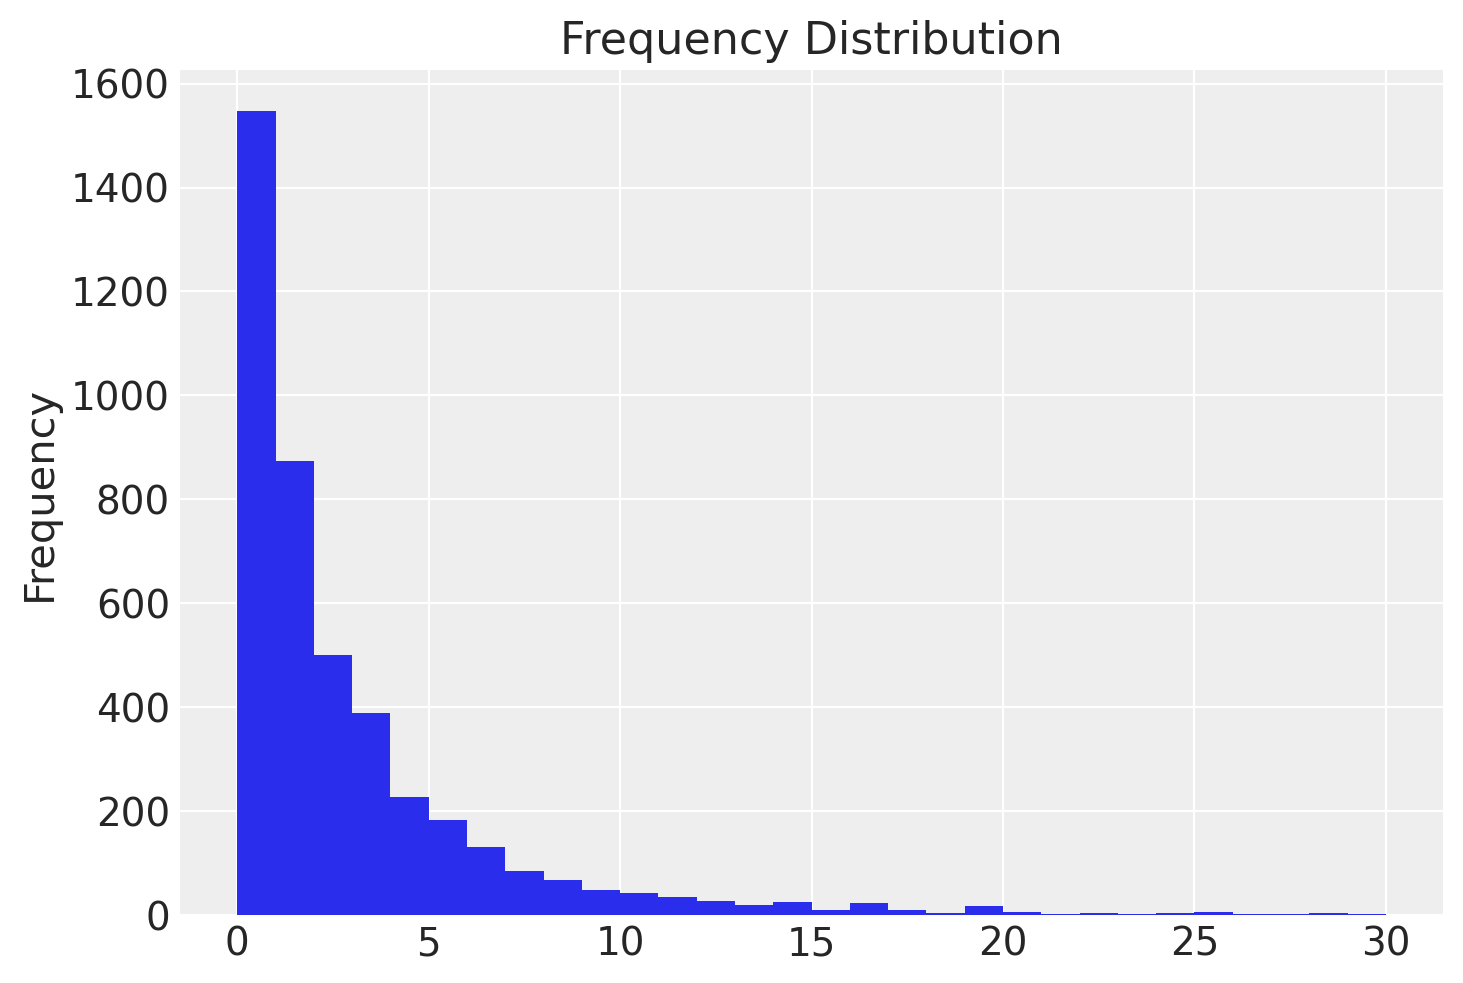

In [148]:
# Plotting the frequency distribution of customers
data_summary_rfm['frequency'].plot(kind='hist', bins=30, title='Frequency Distribution', range=[0, 30])
one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")

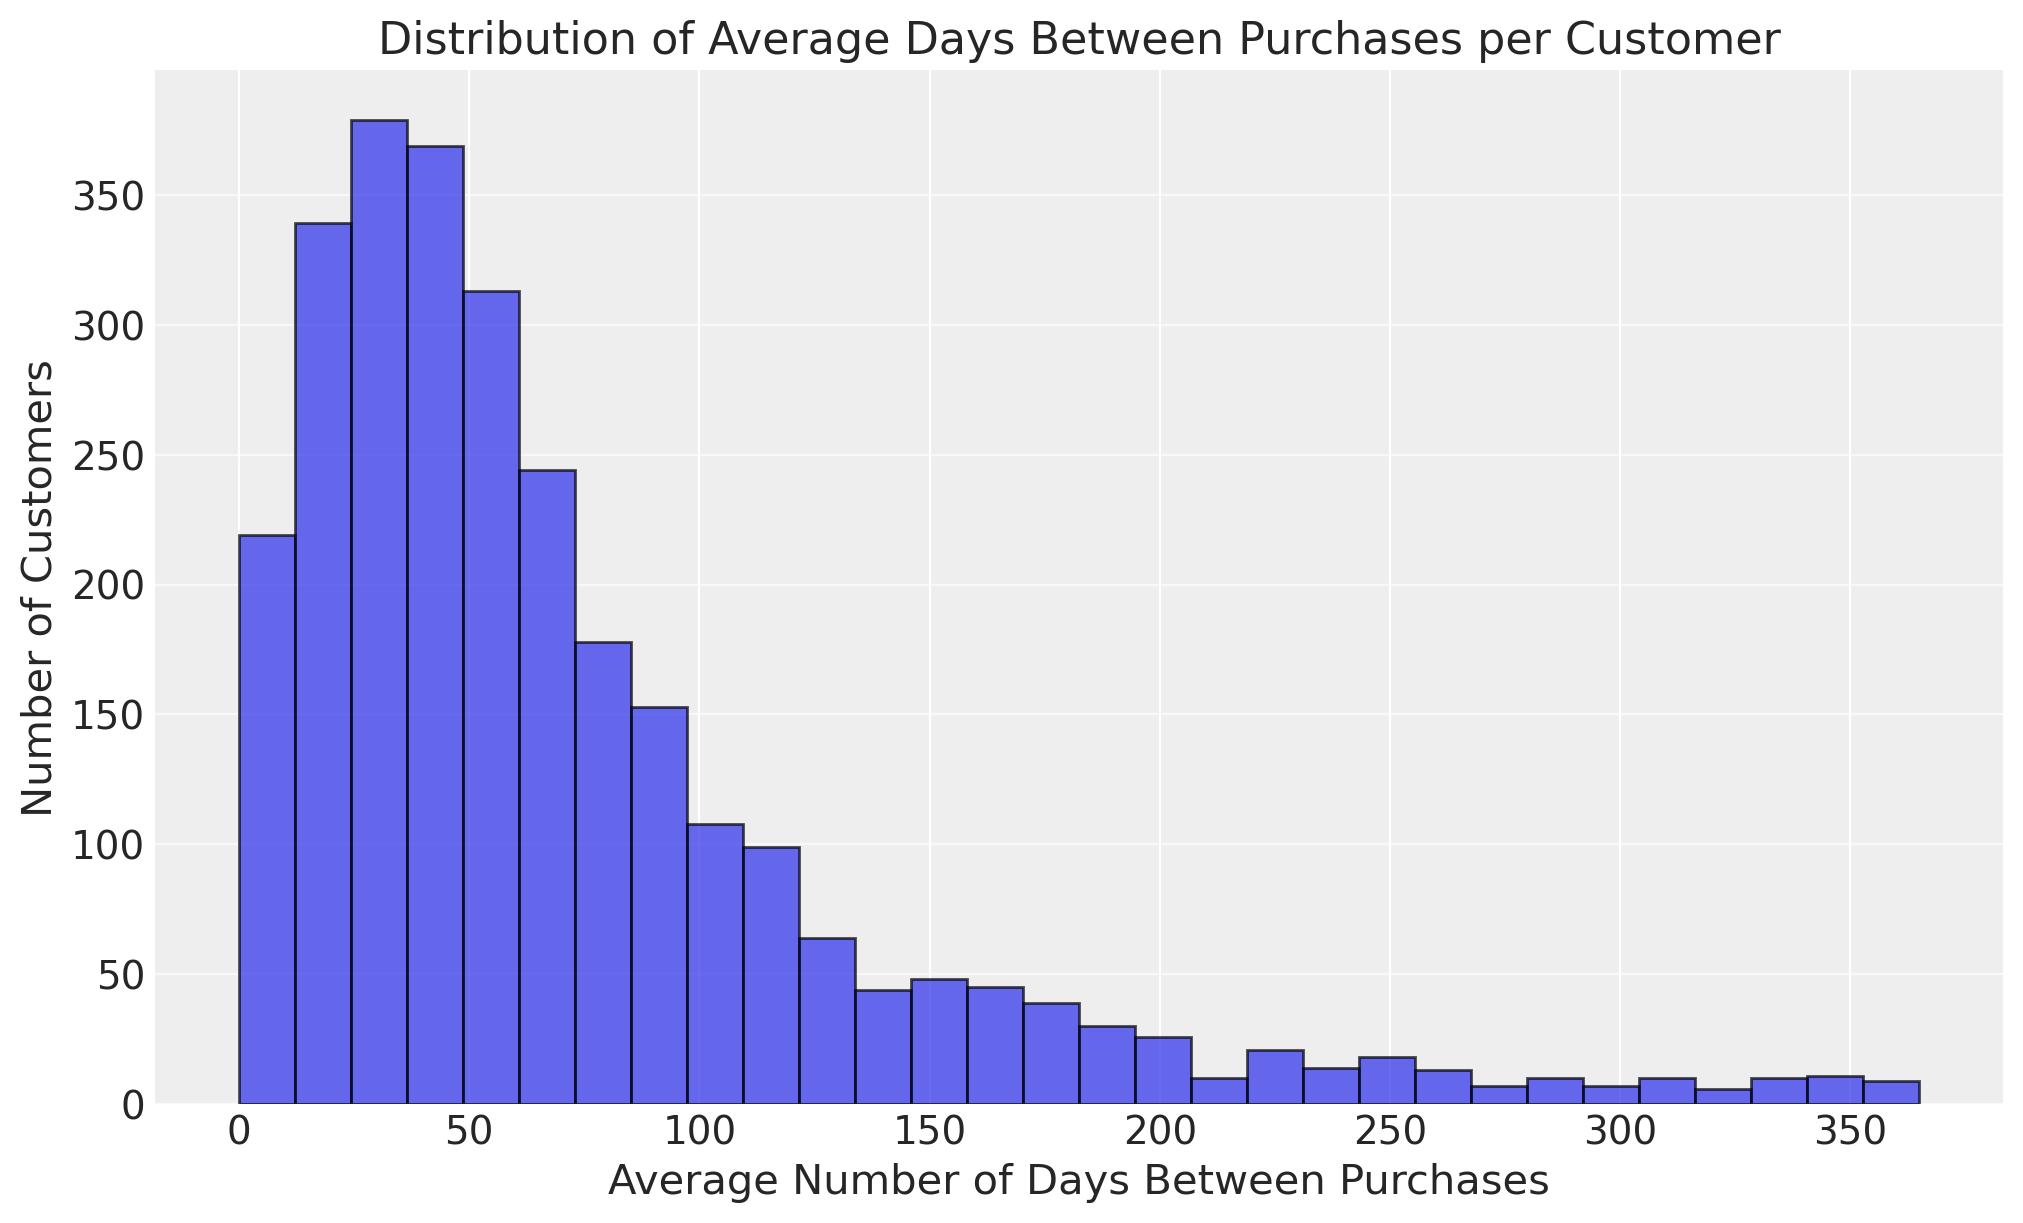

In [149]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
unique_purchases = data[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['CustomerID', 'InvoiceDate'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()



In [150]:
# Initializing the BG/NBD model. This model predicts the purchases customers are likely to make in a future period of time.
# The BG/NBD model accounts for the fact that some customers may have "dropped out" or are no longer active.
bgm = clv.BetaGeoModel(data=data_summary_rfm)
bgm.build_model()

# Note: The BG/NBD model is particularly suitable for non-contractual business settings with continuous customer transactions.

This model has 4 parameters that specify the global frequency and dropout rates of customers.

In [151]:
# Displaying the structure of the BG/NBD model, which internally uses Bayesian statistics concepts.
# The model includes several parameters that control aspects like customer purchase patterns and dropout tendency.

bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

In [152]:
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

The default priors for the 4 parameters follow a HalfFlat distribution, which is an improper positive uniform distribution. For small datasets this prior can yield implausible posteriors. To avoid this problem, more informative priors can be specified by defining custom PyMC distributions.

Here, we will replace the HalfFlat default by more well-behaved HalfNormal priors with a standard deviation of 10.
Customization priors is possible by passing a dictionary with keys being the name of the prior, and values being a dictionary with 2 keys: 'dist' representing the name of PyMC distribution and 'kwargs' that holds an optional dictionary of all parameters we wish to pass to the distribution

In [153]:
# While the default priors work well for large datasets, they can be too broad or non-informative for smaller datasets.
# Therefore, we're refining our model by specifying more informative priors for the model's parameters.
# This step helps in guiding the model towards more realistic areas of the parameter space.

model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
}

In [154]:
# Rebuilding the model with updated prior configurations.
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 100)
         b ~ HalfNormal(0, 100)
     alpha ~ HalfNormal(0, 100)
         r ~ HalfNormal(0, 100)
likelihood ~ Potential(f(r, alpha, b, a))

Having specified the model, we can now fit it.

In [155]:
# After defining the model, we proceed with fitting it to our data.
# This step involves estimating the model parameters from our data, essentially learning the customers' purchasing behaviors.

bgm.fit()
bgm.fit_summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.079,0.083,0.000,0.229,0.002,0.001,1323.0,1305.0,1.0
b,117.211,64.747,8.931,233.717,1.527,1.080,1596.0,1333.0,1.0
alpha,68.840,2.603,63.799,73.545,0.069,0.049,1405.0,1623.0,1.0
r,0.826,0.027,0.777,0.875,0.001,0.000,1462.0,1880.0,1.0


We can use [ArviZ](https://python.arviz.org/en/stable/), a Python library tailored to produce visualizations for Bayesian models, to plot the posterior distribution of each parameter.

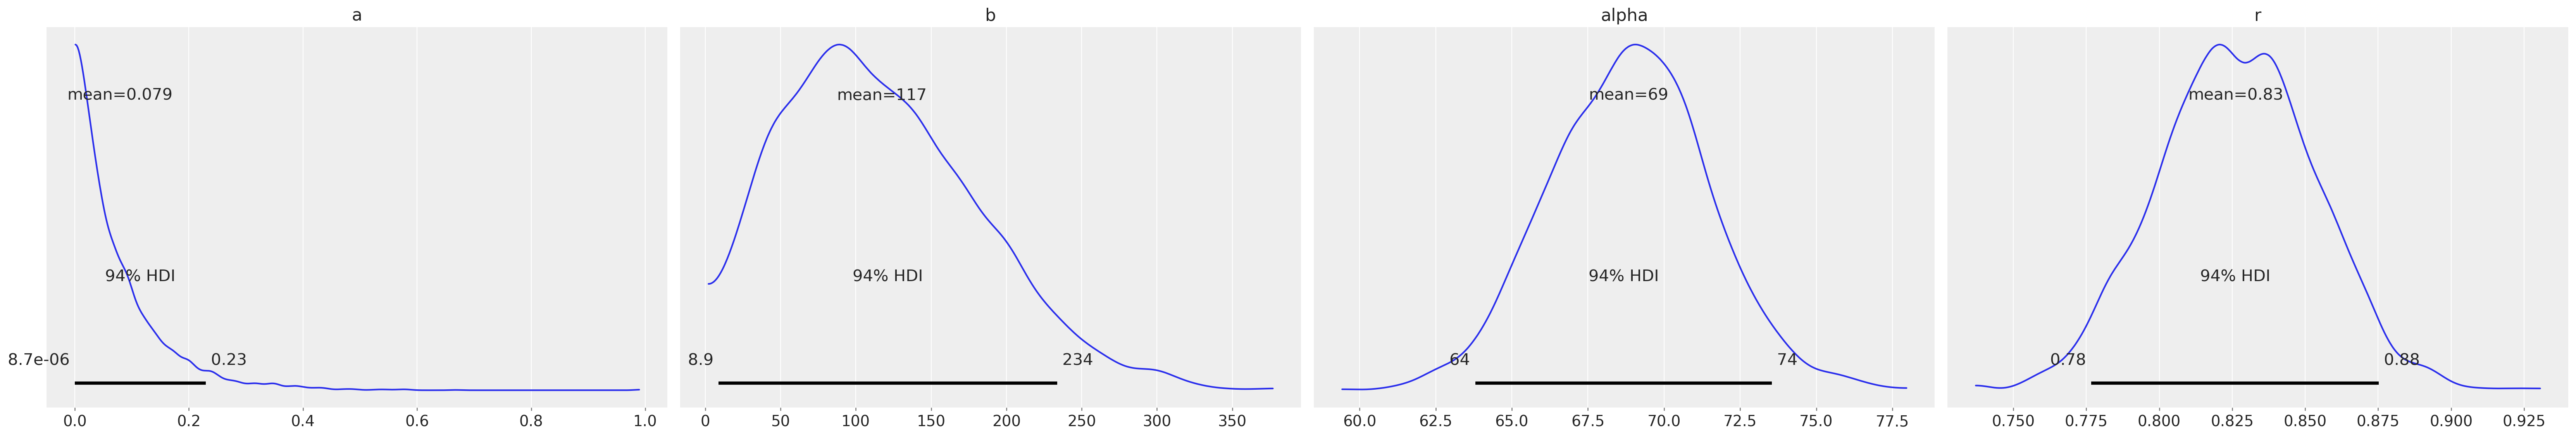

In [156]:
# Visualizing the posterior distributions of the parameters.
# These distributions show the range of probable values for each parameter, considering the observed data.

az.plot_posterior(bgm.fit_result);

The spread of the distributions indicates the uncertainty in the estimates. Narrower distributions suggest more precise estimates.

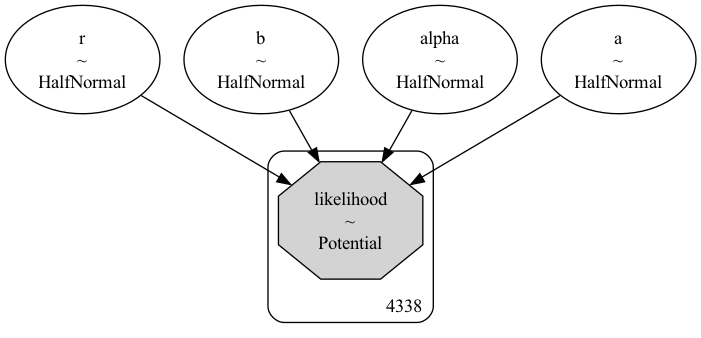

In [157]:
graph = pm.model_to_graphviz(bgm.model)

img = graph.pipe(format='png')
Image(img)

### Visualizing the Frequency/Recency Matrix

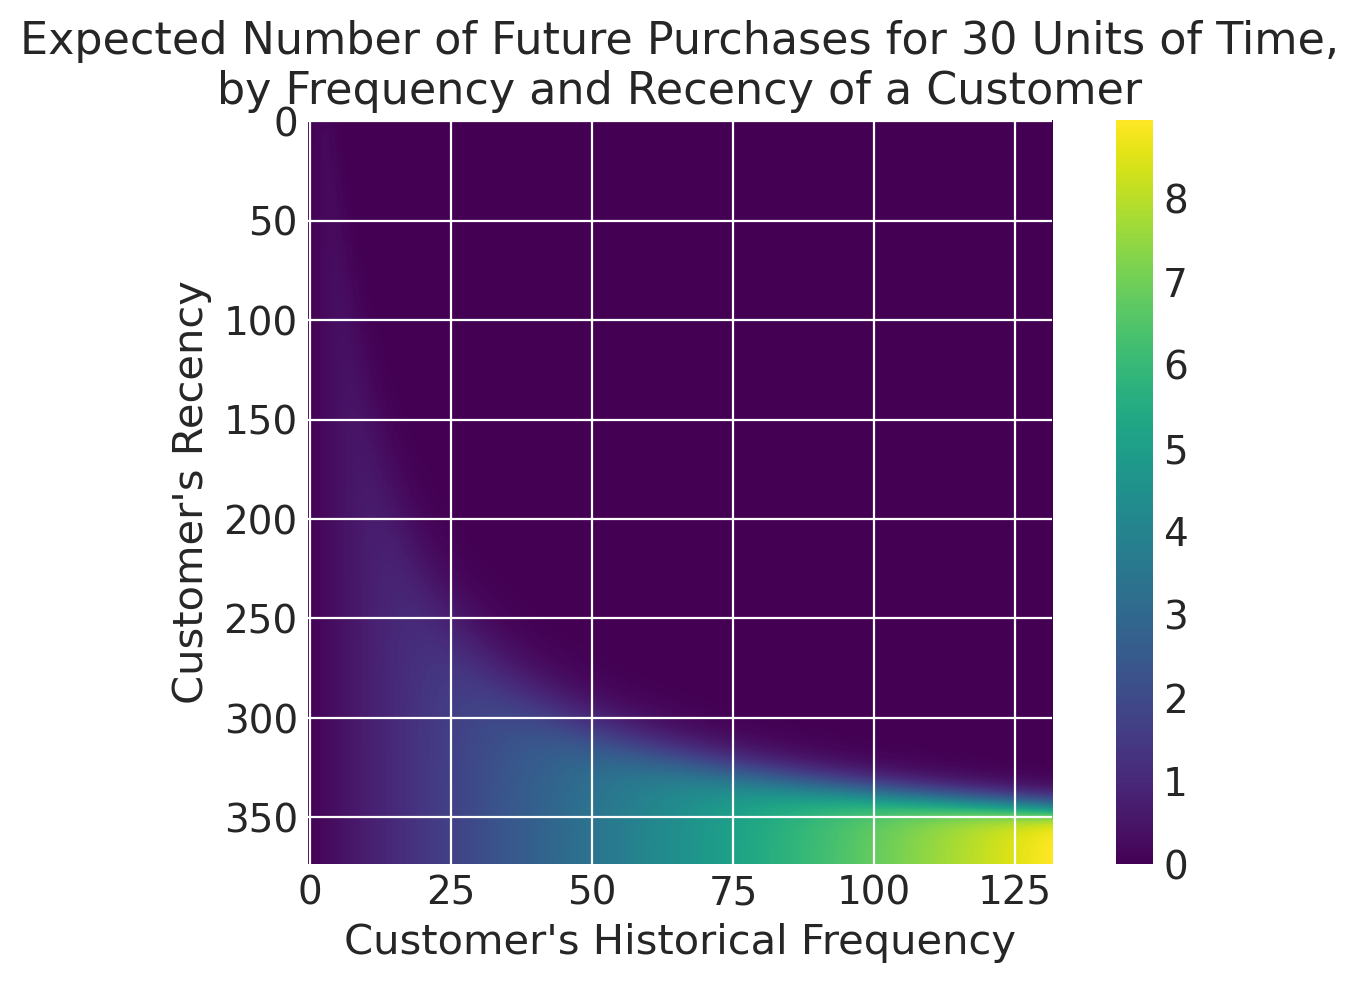

In [158]:
# Analyzing customer behavior using a Frequency/Recency matrix, which visualizes customer archetypes.
# This matrix helps in identifying patterns like potentially "at-risk" customers who might churn.
clv.plot_frequency_recency_matrix(bgm, t=30);

Observations from the matrix can guide strategies to possibly re-engage fading customers or reward loyal ones.

Your best customer are those in the bottom-right: They have bought frequently and they are still buying. Your "coldest" customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

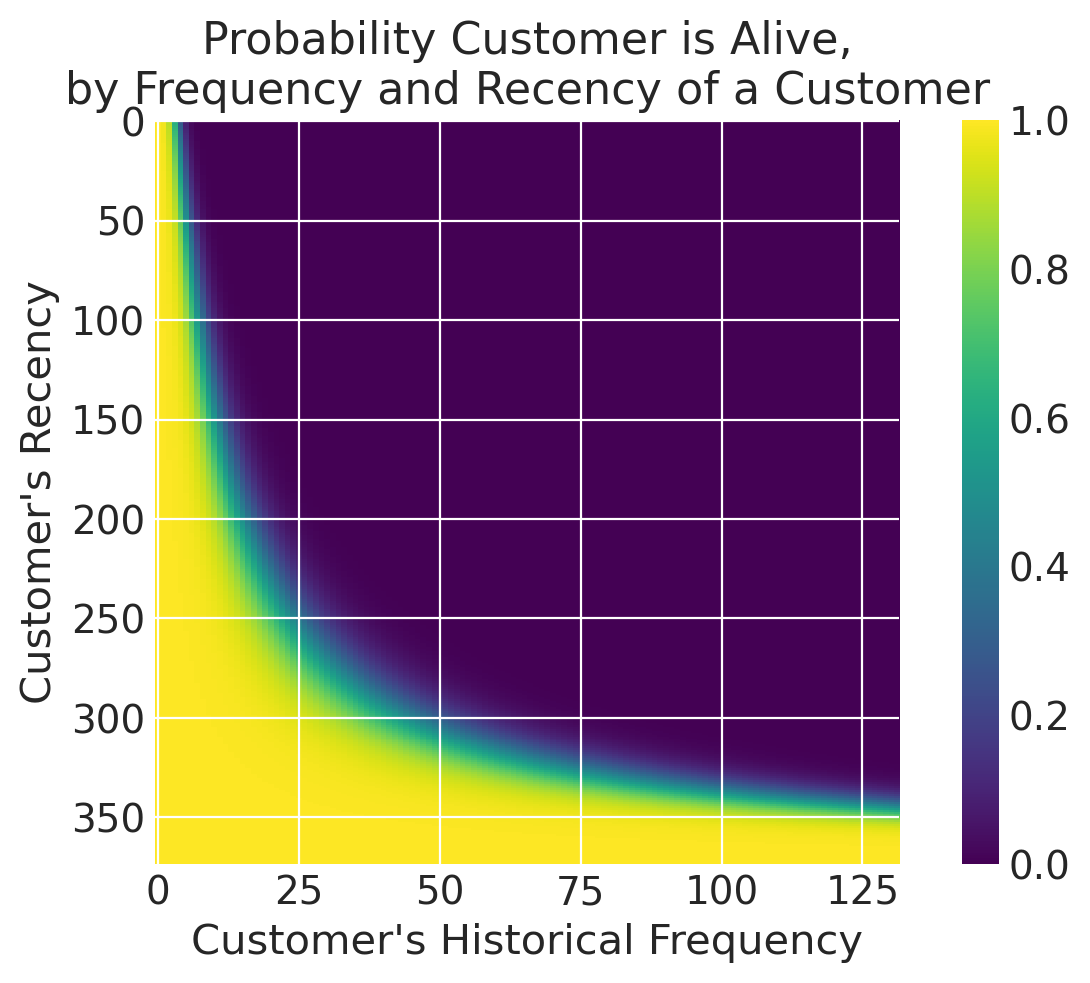

In [159]:
# The Probability Alive Matrix visualizes the likelihood of customers still being active.
# This view is essential for identifying potentially lost customers and understanding overall customer retention.

clv.plot_probability_alive_matrix(bgm);

Looking at the probability alive matrix, we can infer that users who have made a lot of purchases a long time ago are likely to never return.

### Predict the number of purchases

In [160]:
# Predicting future purchases within the next 30 days using the fitted model.

num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm["customer_id"],
    t=30,
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"]
)

In [161]:
# We add expected purchases to our data summary and display the customers with the highest expected purchases.
# These are customers who are most likely to buy again, representing high-value segments for marketing initiatives.

sdata = data_summary_rfm.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,index,customer_id,frequency,recency,T,monetary_value,expected_purchases
2176,2176,15311,89.0,373.0,373.0,677.729438,6.090378
4010,4010,17841,111.0,372.0,373.0,364.452162,7.580584
326,326,12748,112.0,373.0,373.0,301.024821,7.649057
1879,1879,14911,131.0,372.0,373.0,1093.661679,8.935613


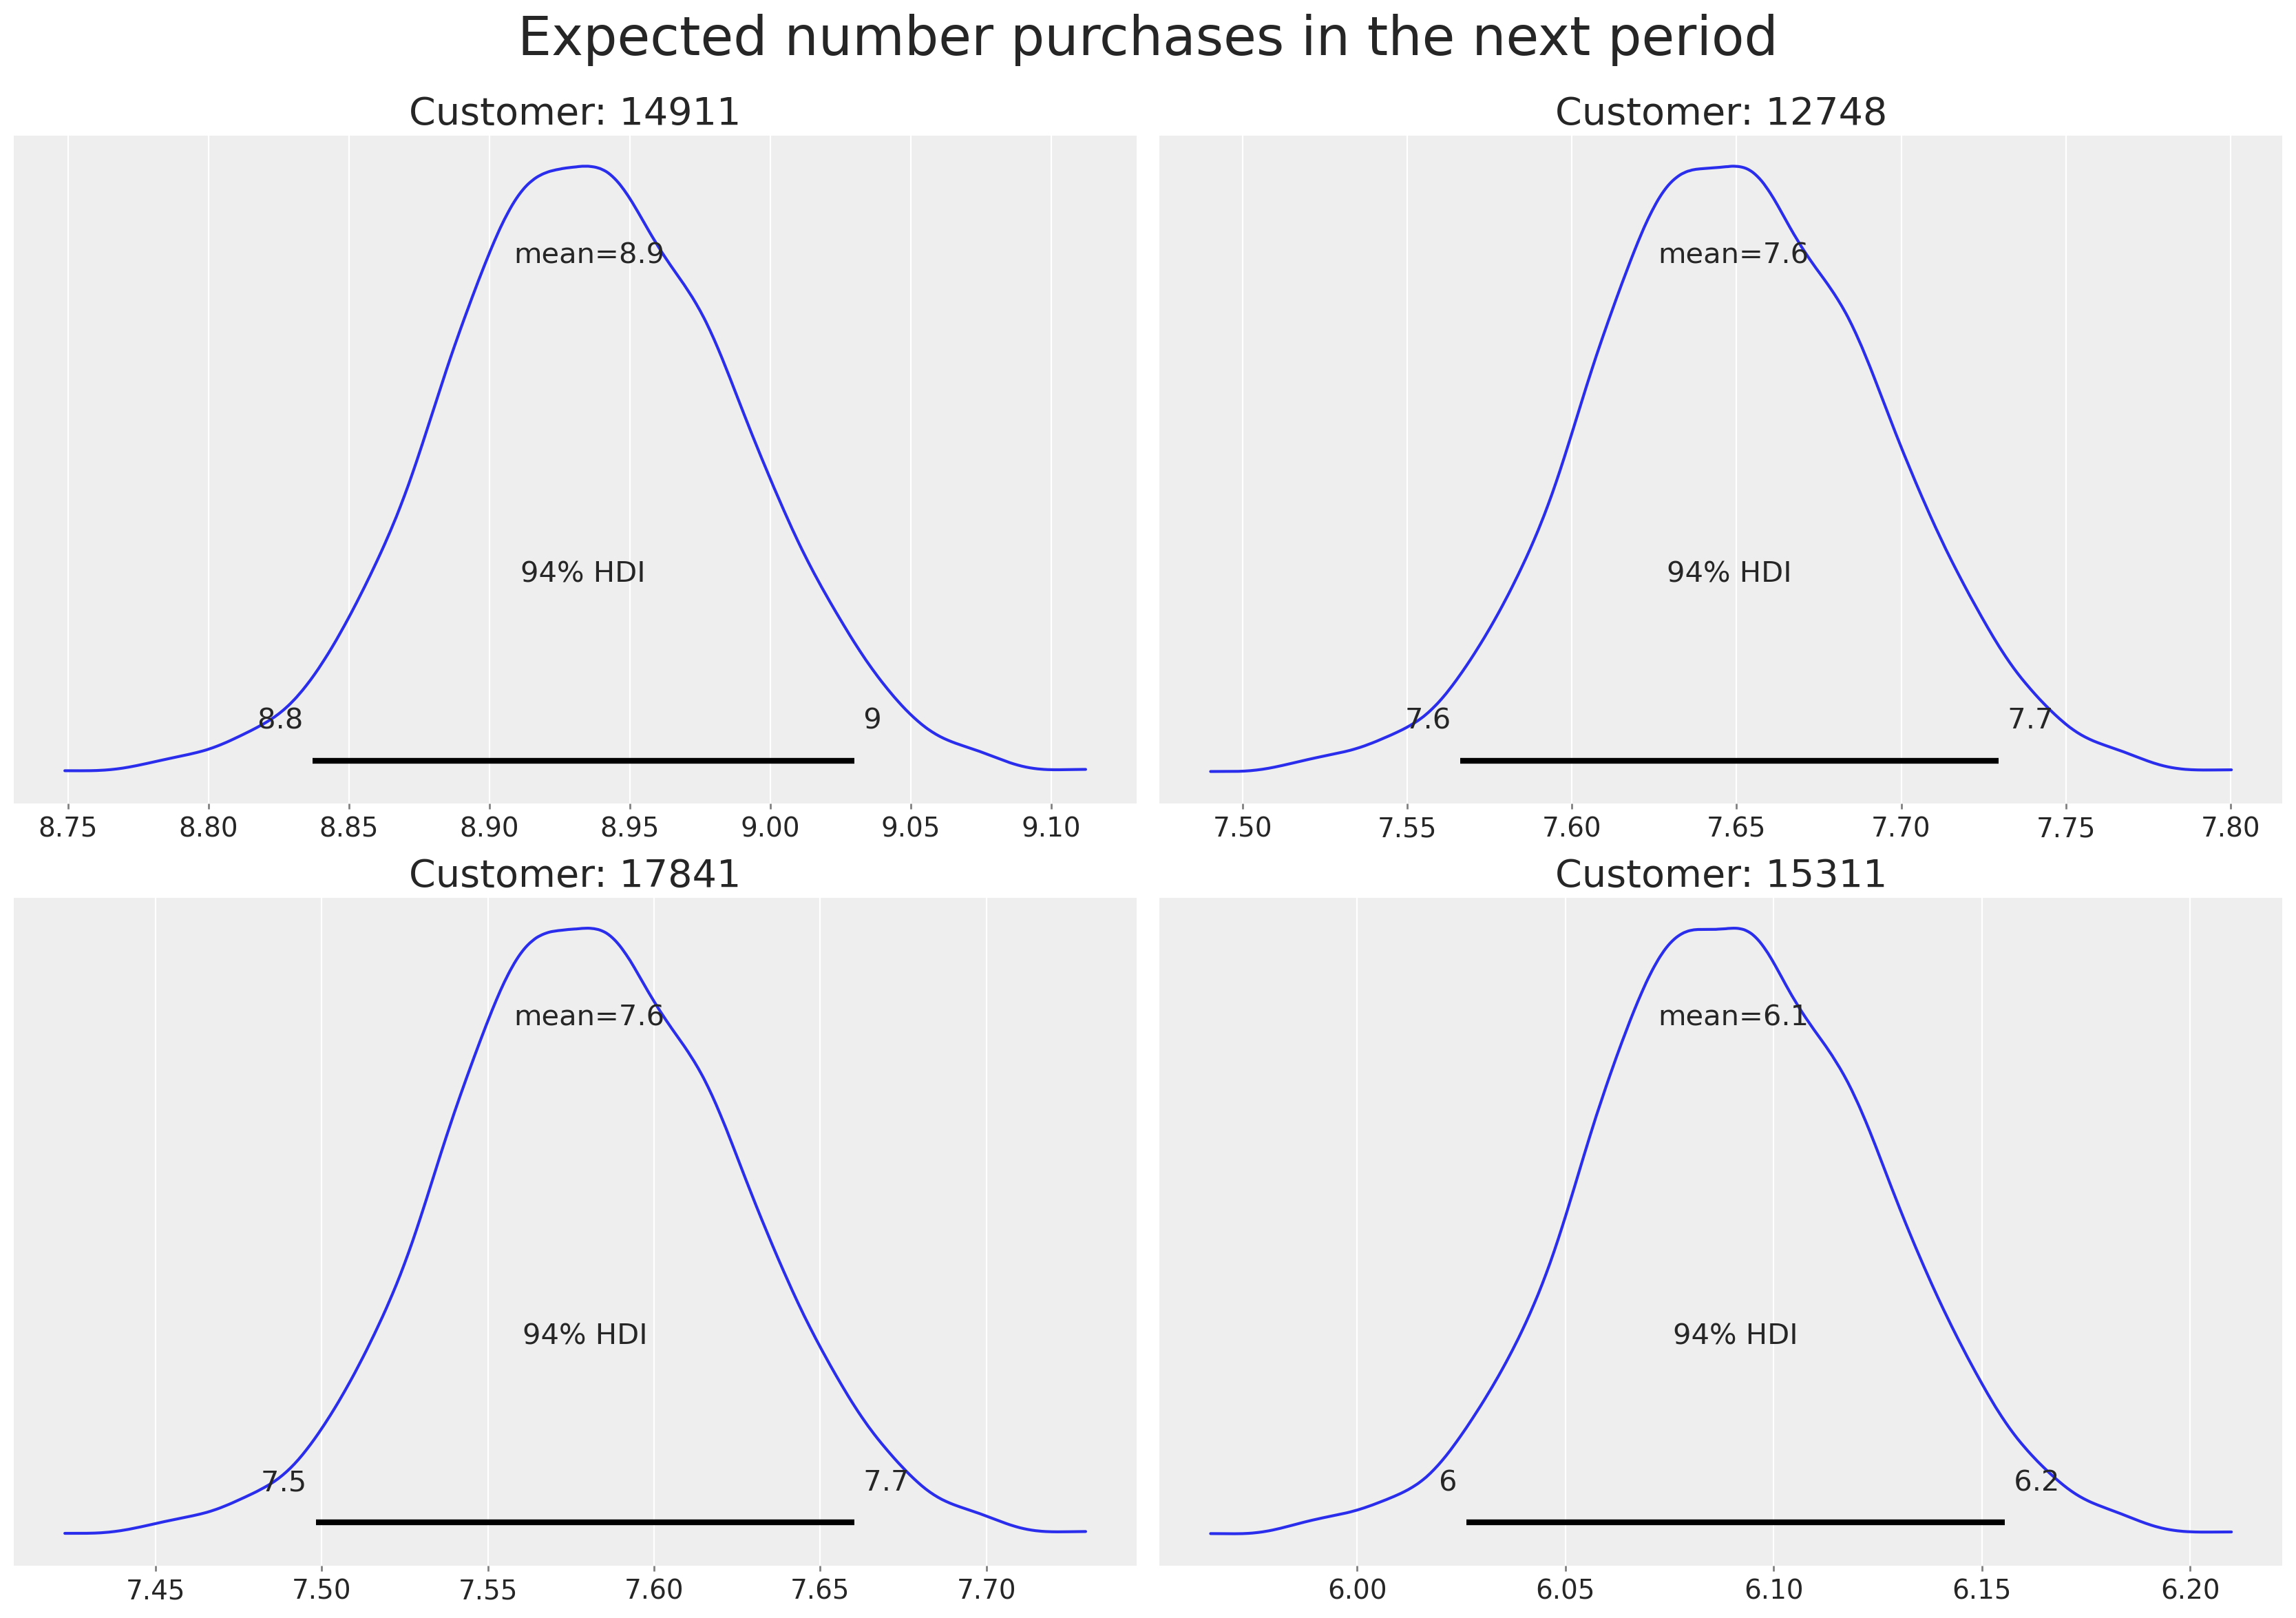

In [167]:
# Here, we're visualizing the uncertainty in our predictions for the number of purchases.
# This step illustrates the range of likely outcomes, highlighting the probabilistic nature of our predictions.

ids = sdata.sort_values(by="expected_purchases", ascending=False).head(4)['customer_id'].tolist()
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

### Predicting purchase behavior of a new customer

We can use the fitted model to predict the number of purchases for a fresh new customer.

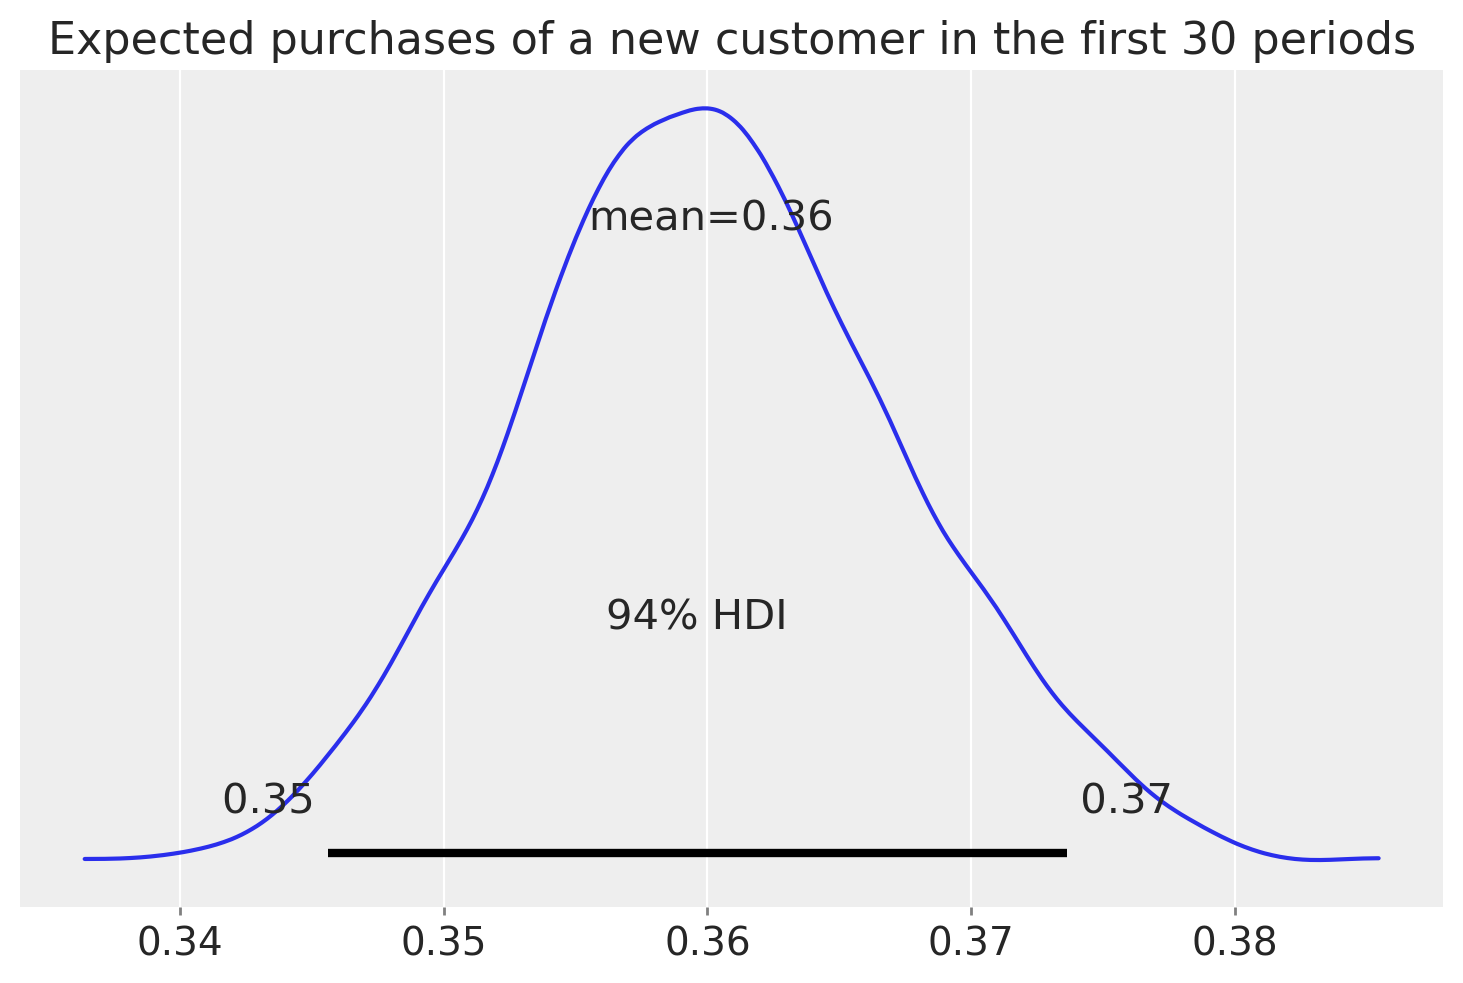

In [168]:
# Estimating the purchasing behavior of a completely new customer.
# This prediction is useful for understanding what purchasing behavior might be expected from prospective customers.

az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=30)
);
plt.title("Expected purchases of a new customer in the first 30 periods");

### Customer Probability Histories

Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. 

In [169]:
# Selecting a specific customer (ID 1879) to visualize their transaction history and model their future transaction probability.

customer_number_viz = 1879
customer_viz = data_summary_rfm.loc[customer_number_viz]
customer_viz  # Displaying the selected customer's historical summary.

index                    1879
customer_id             14911
frequency               131.0
recency                 372.0
T                       373.0
monetary_value    1093.661679
Name: 1879, dtype: object

In [170]:
# Constructing a hypothetical future transaction history for the selected customer over a set period (30 units of time).
# This synthetic data will allow us to model potential future activity and assess the customer's probability of remaining active.

data_range = 30
customer_viz_history = pd.DataFrame(dict(
    ID=np.full(data_range, customer_number_viz, dtype="int"),
    frequency=np.full(data_range, customer_viz["frequency"], dtype="int"),
    recency=np.full(data_range, customer_viz["recency"]),
    T=(np.arange(-1, data_range-1) + customer_viz["T"]).astype("int"),

))
customer_viz_history # Viewing the constructed future transaction history.

,ID,frequency,recency,T
0,1879,131,372.0,372
1,1879,131,372.0,373
2,1879,131,372.0,374
3,1879,131,372.0,375
4,1879,131,372.0,376
5,1879,131,372.0,377
6,1879,131,372.0,378
7,1879,131,372.0,379
8,1879,131,372.0,380
9,1879,131,372.0,381


In [171]:
# Calculating the probability of this customer being still active (alive) using the BG/NBD model.
# This step predicts the likelihood of the customer returning for future purchases based on their transaction history.

p_alive = bgm.expected_probability_alive(
    customer_id=customer_viz_history["ID"],
    frequency=customer_viz_history["frequency"],
    recency=customer_viz_history["recency"],
    T=customer_viz_history["T"],
)

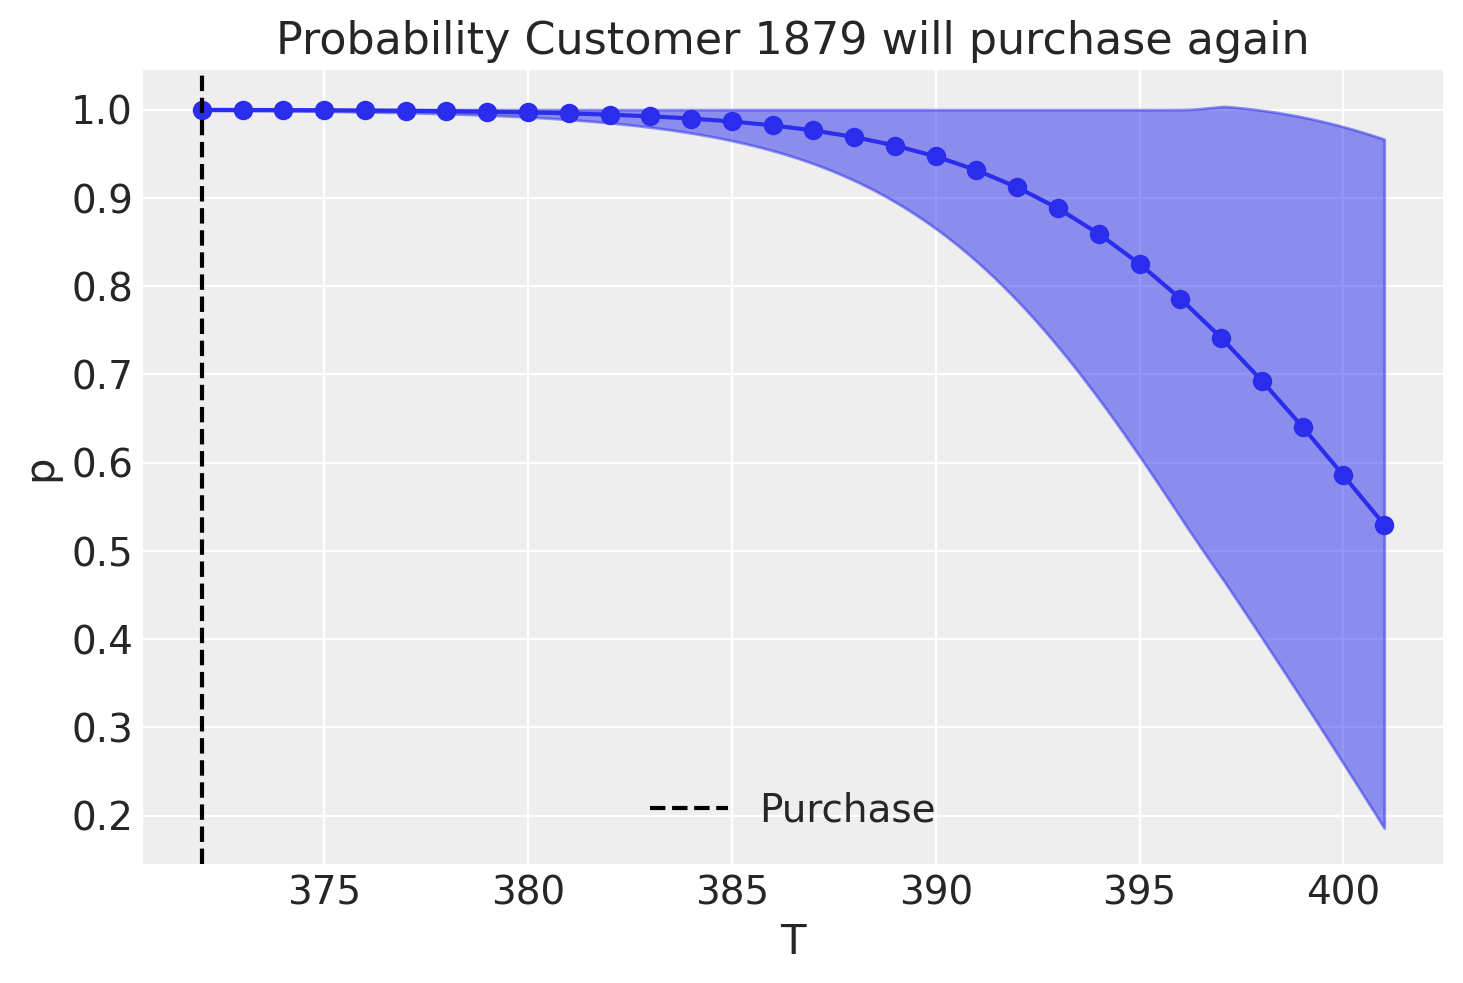

In [172]:
# Visualizing the customer's probability of remaining active over the forecasted period.
# The shaded area represents the confidence interval, providing a range where the actual probability is likely to fall.

az.plot_hdi(customer_viz_history["T"], p_alive, color="C0")
plt.plot(customer_viz_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_viz_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title(f"Probability Customer {customer_number_viz} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

Note: The plot suggests that the likelihood of a customer returning decreases the longer they go without making a purchase.

In [173]:
# Now, let's simulate a scenario where the customer makes an additional purchase during the forecast period.
# We adjust the customer's transaction history to reflect this new purchase and observe its impact on their active probability.

customer_viz_history["frequency"].iloc[-10:] += 1
customer_viz_history["recency"].iloc[-10:] = customer_viz_history["T"].iloc[-10] - 0.5
customer_viz_history

/var/folders/8y/d978l_411v9gwlklh7b5rydh0000gn/T/ipykernel_69212/3516554638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_viz_history["frequency"].iloc[-10:] += 1
/var/folders/8y/d978l_411v9gwlklh7b5rydh0000gn/T/ipykernel_69212/3516554638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_viz_history["recency"].iloc[-10:] = customer_viz_history["T"].iloc[-10] - 0.5


,ID,frequency,recency,T
0,1879,131,372.0,372
1,1879,131,372.0,373
2,1879,131,372.0,374
3,1879,131,372.0,375
4,1879,131,372.0,376
5,1879,131,372.0,377
6,1879,131,372.0,378
7,1879,131,372.0,379
8,1879,131,372.0,380
9,1879,131,372.0,381


In [174]:
# Recalculating the probability of being alive based on the updated transaction history.

p_alive = bgm.expected_probability_alive(
    customer_id=customer_viz_history["ID"],
    frequency=customer_viz_history["frequency"],
    recency=customer_viz_history["recency"],
    T=customer_viz_history["T"],
)

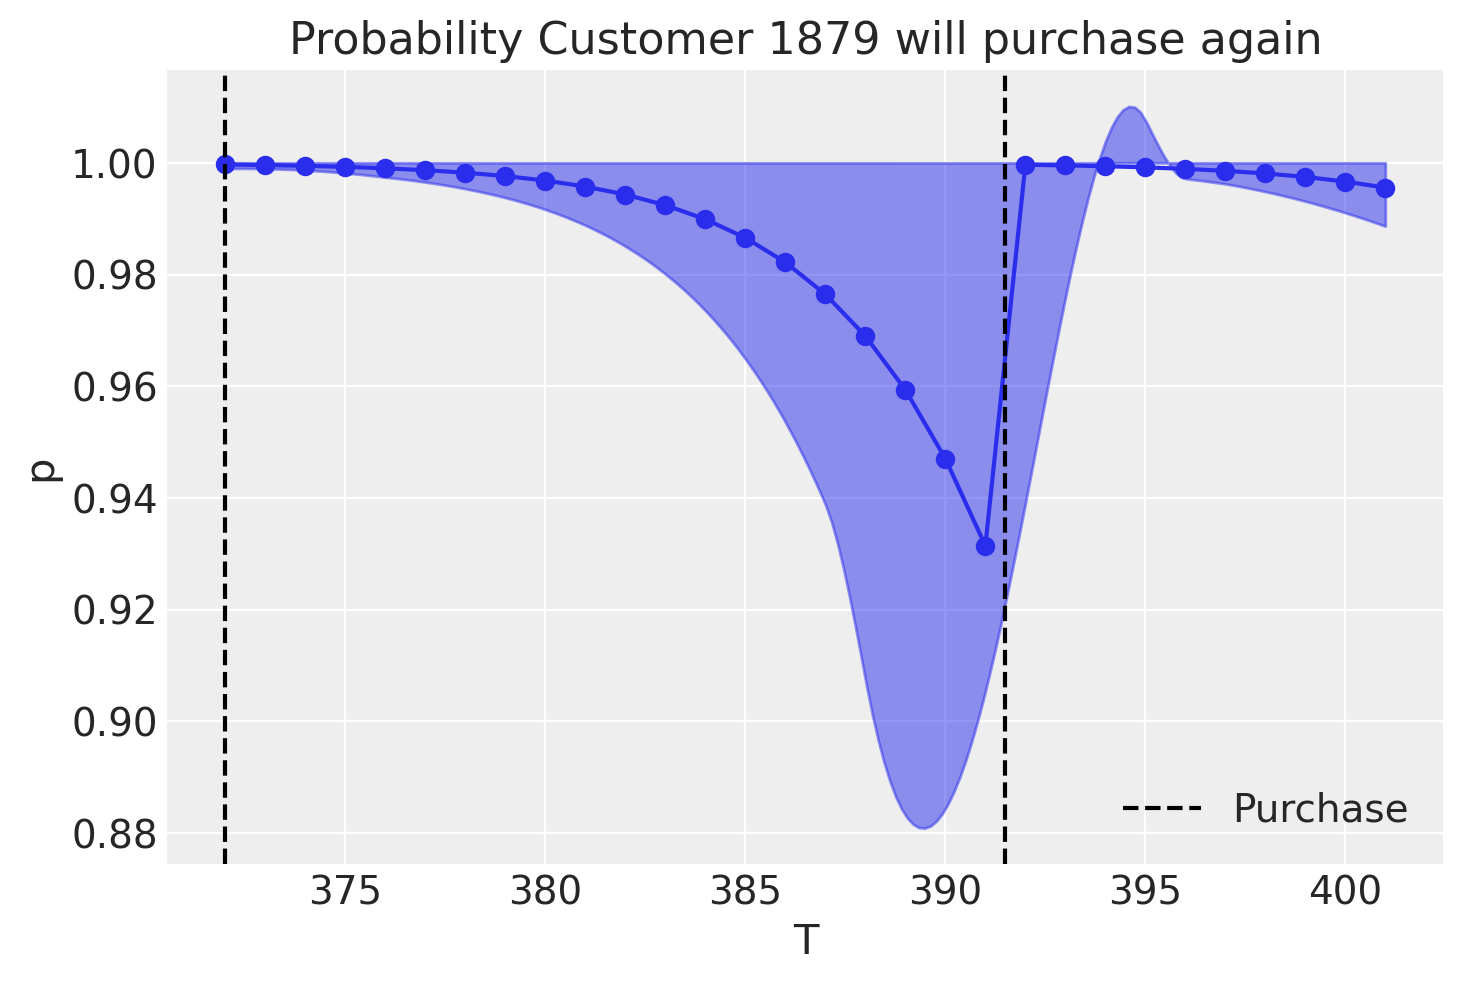

In [175]:
# Plotting the revised probability of the customer remaining active.
# The new purchase is marked, indicating its positive impact on the customer's likelihood of returning for more purchases.

az.plot_hdi(customer_viz_history["T"], p_alive, color="C0")
plt.plot(customer_viz_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_viz_history["recency"].iloc[0], c="black", ls="--", label="Purchase")
plt.axvline(customer_viz_history["recency"].iloc[-1], c="black", ls="--")

plt.title(f"Probability Customer {customer_number_viz} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

From the plot above, say that this customer makes a purchase at week 36.5, roughly ~6 weeks after they have made their last recorded purchase at time 30.86 weeks according to the data. We can see that the probability of the customer returning quickly goes back up!

In other words, for every purchase, the probability of a customer returning for a/more purchase(s) increases. Similarly, as time goes by where a customer makes no purchase, the likelihood of them returning for a purchases decreases with time.

# Gamma-Gamma model


The Gamma-Gamma model is now used to estimate the monetary value aspect of customer lifetime value (CLV).
This model assumes that while customers have different average transaction values, the variation in transaction value among transactions is independent of the variation between customers.


In [176]:
# Filtering out customers with zero frequency to fit the Gamma-Gamma model.
# This model requires customers to have made at least one repeat purchase.

nonzero_data = data_summary_rfm.query("frequency>0")
nonzero_data

,index,customer_id,frequency,recency,T,monetary_value
1,1,12347,6.0,365.0,367.0,599.701667
2,2,12348,3.0,283.0,358.0,301.480000
5,5,12352,6.0,260.0,296.0,368.256667
9,9,12356,2.0,303.0,325.0,269.905000
11,11,12358,1.0,149.0,150.0,683.200000
...,...,...,...,...,...,...
4327,4327,18272,5.0,244.0,246.0,487.752000
4328,4328,18273,2.0,255.0,257.0,76.500000
4335,4335,18282,1.0,119.0,126.0,77.840000
4336,4336,18283,13.0,334.0,337.0,152.802308


The Gamma-Gamma model takes in a 'data' parameter, a pandas DataFrame with 3 columns that contain the group expected mean spend and expected individual variation around that mean. As with the BG/NBD model, these parameters are given HalfFlat priors which can be too diffuse for small datasets. For this example, we will use the default priors, but other priors can be specified just like with the BG/NBD example above.

In [177]:
# Preparing the data for the Gamma-Gamma model. This model predicts the average transaction value for each customer, 
# given the number of transactions they have made (frequency) and their average transaction value so far.

dataset = pd.DataFrame({
    'customer_id': nonzero_data.customer_id,
    'mean_transaction_value': nonzero_data["monetary_value"],
    'frequency': nonzero_data["frequency"],
})

In [178]:
# Initializing the Gamma-Gamma model with the prepared data.

gg = clv.GammaGammaModel(
    data = dataset
)
gg.build_model()
gg

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

By default, `fit` approximates full Bayesian posterior using [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) sampling provided by `pymc.sample`. If the full posterior is not needed or MCMC sampling is too slow, users can obtain the single [maximum a posteriori estimate](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) via the `fit_method` kwarg.

In [179]:
# Fitting the Gamma-Gamma model to the data.
# Instead of full Bayesian inference which can be computationally intensive, we're using maximum a posteriori (MAP) estimation.
# MAP provides a good point estimate faster, especially useful for large datasets or when computational resources are limited.

gg.fit(fit_method="map");

In [180]:
# After fitting, we examine the model's summary and posterior distributions to understand the estimated parameters' characteristics.
# These insights help validate the model's fit and assess the reliability of its predictions.

gg.fit_summary()

p      2.103
q      3.451
v    485.884
Name: value, dtype: float64

In [181]:
gg.fit();

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [182]:
# Displaying a summary of the model's fit to understand the estimated parameters' characteristics better.
# This summary provides insights into the convergence of the model and the reliability of its predictions.

gg.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,2.105,0.113,1.903,2.321,0.003,0.002,1058.0,1224.0,1.0
q,3.461,0.140,3.204,3.724,0.004,0.003,1181.0,1484.0,1.0
v,489.116,42.410,412.900,568.661,1.420,1.005,888.0,1256.0,1.0


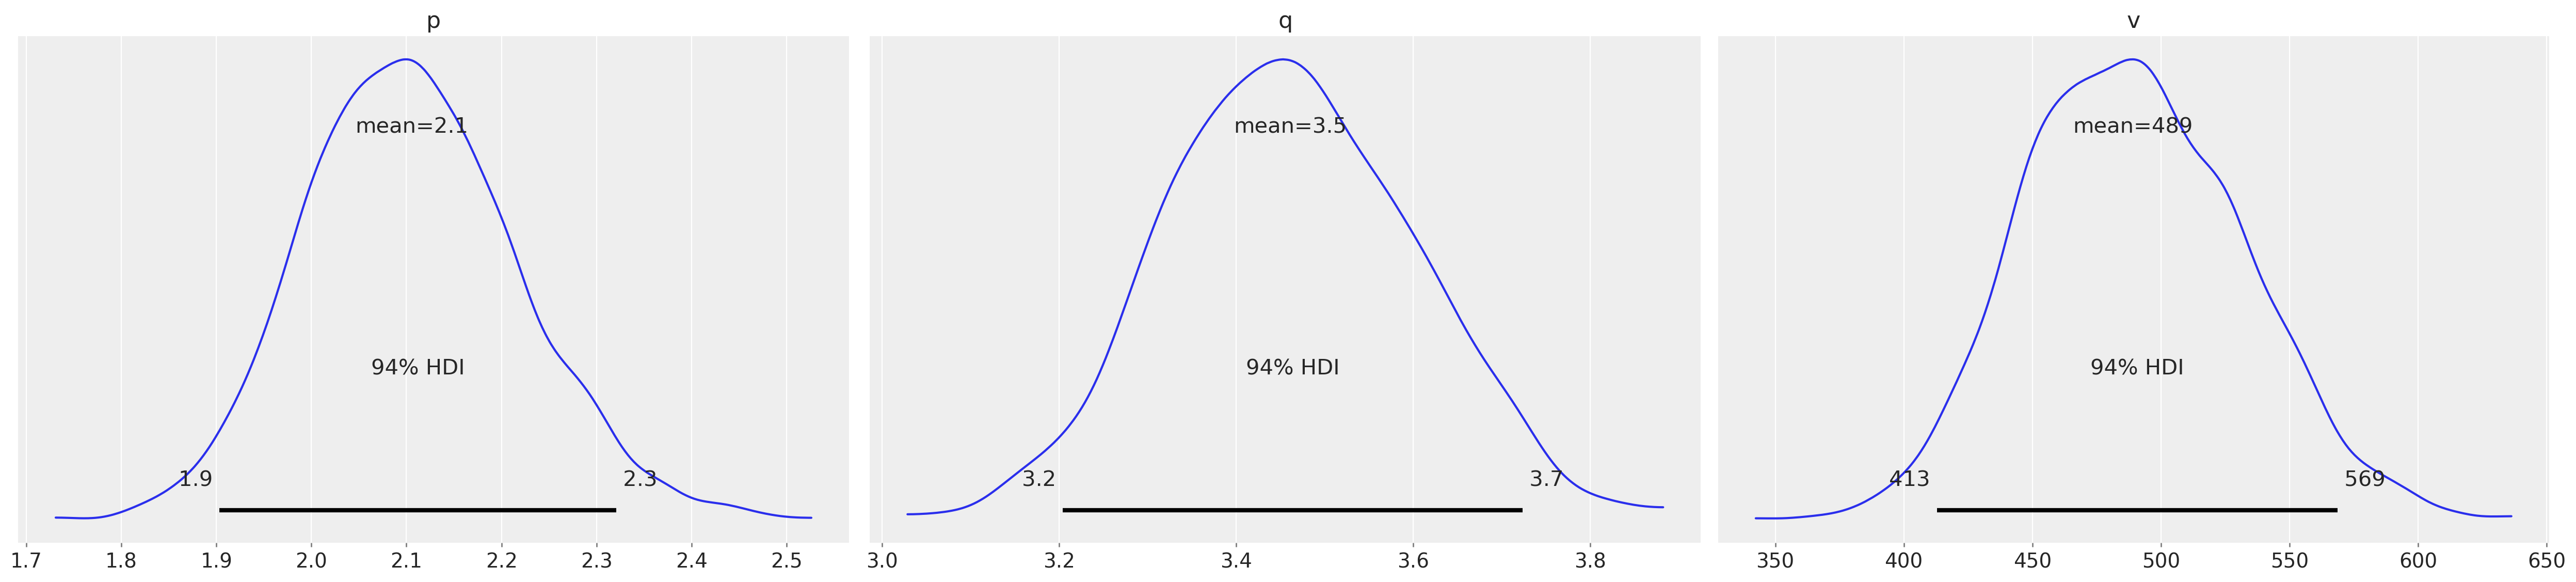

In [183]:
# Visualizing the posterior distributions of the estimated parameters using ArviZ.
# These plots help us assess the uncertainty surrounding our estimates, which is crucial for informed decision-making.

az.plot_posterior(gg.fit_result);

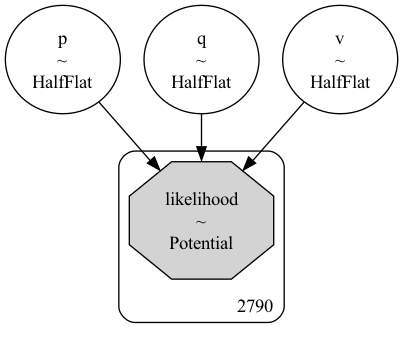

In [184]:
graph = pm.model_to_graphviz(gg.model)

img = graph.pipe(format='png')
Image(img)

### Predicting Customer Spending

Having fit our model, we can now use it to predict the conditional, expected average lifetime value of our customers, including those with zero repeat purchases.

In [185]:
# Calculating the conditional expected average spend for each customer.
# This metric represents the expected average revenue from a customer, given their past behavior.

expected_spend = gg.expected_customer_spend(
    customer_id=data_summary_rfm["customer_id"],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
)

In [186]:
# Summarizing the expected spend statistics for the first ten customers.
# These statistics help us understand the range of likely values for the expected spend metric.

az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[12346],417.066,7.714,403.220,432.368
x[12347],569.830,2.921,564.004,574.899
x[12348],333.879,2.497,329.256,338.568
x[12349],417.066,7.714,403.220,432.368
x[12350],417.066,7.714,403.220,432.368
x[12352],376.201,1.210,373.915,378.457
x[12353],417.066,7.714,403.220,432.368
x[12354],417.066,7.714,403.220,432.368
x[12355],417.066,7.714,403.220,432.368
x[12356],324.163,3.479,317.809,330.763


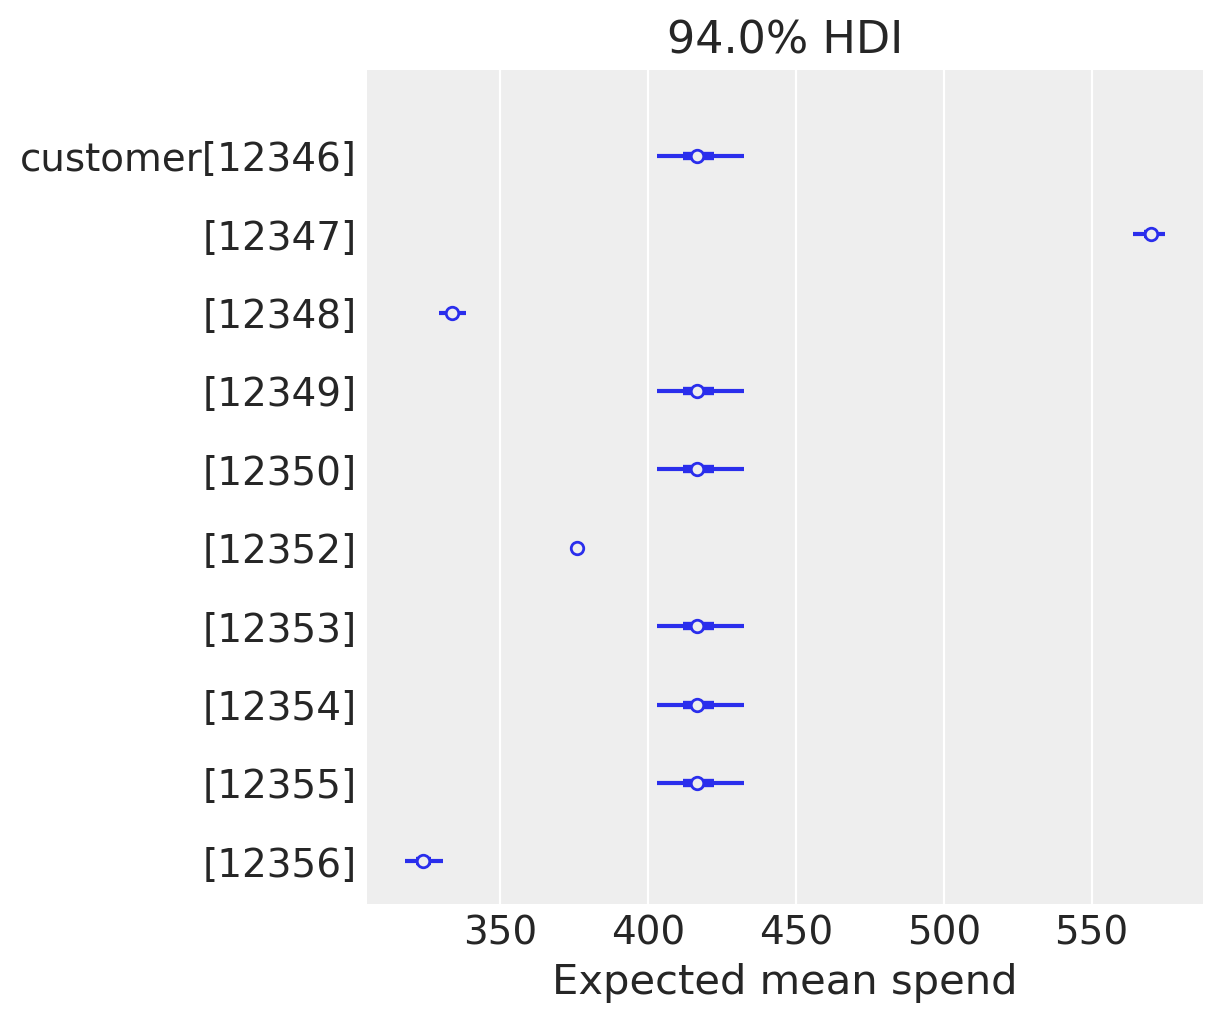

In [187]:
# Creating a forest plot to visualize the expected spend across customers.
# This plot helps identify high-value customers who are likely to spend more in the future.

labeller = MapLabeller(var_name_map={"x": "customer"})
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True, labeller=labeller)
plt.xlabel("Expected mean spend");

We can also look at the average expected mean spend across all customers

In [188]:
# Analyzing the overall average expected spend across all customers.
# This aggregate metric provides a broad view, useful for strategic planning and overall revenue forecasting.

az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,441.183,4.612,431.714,449.243


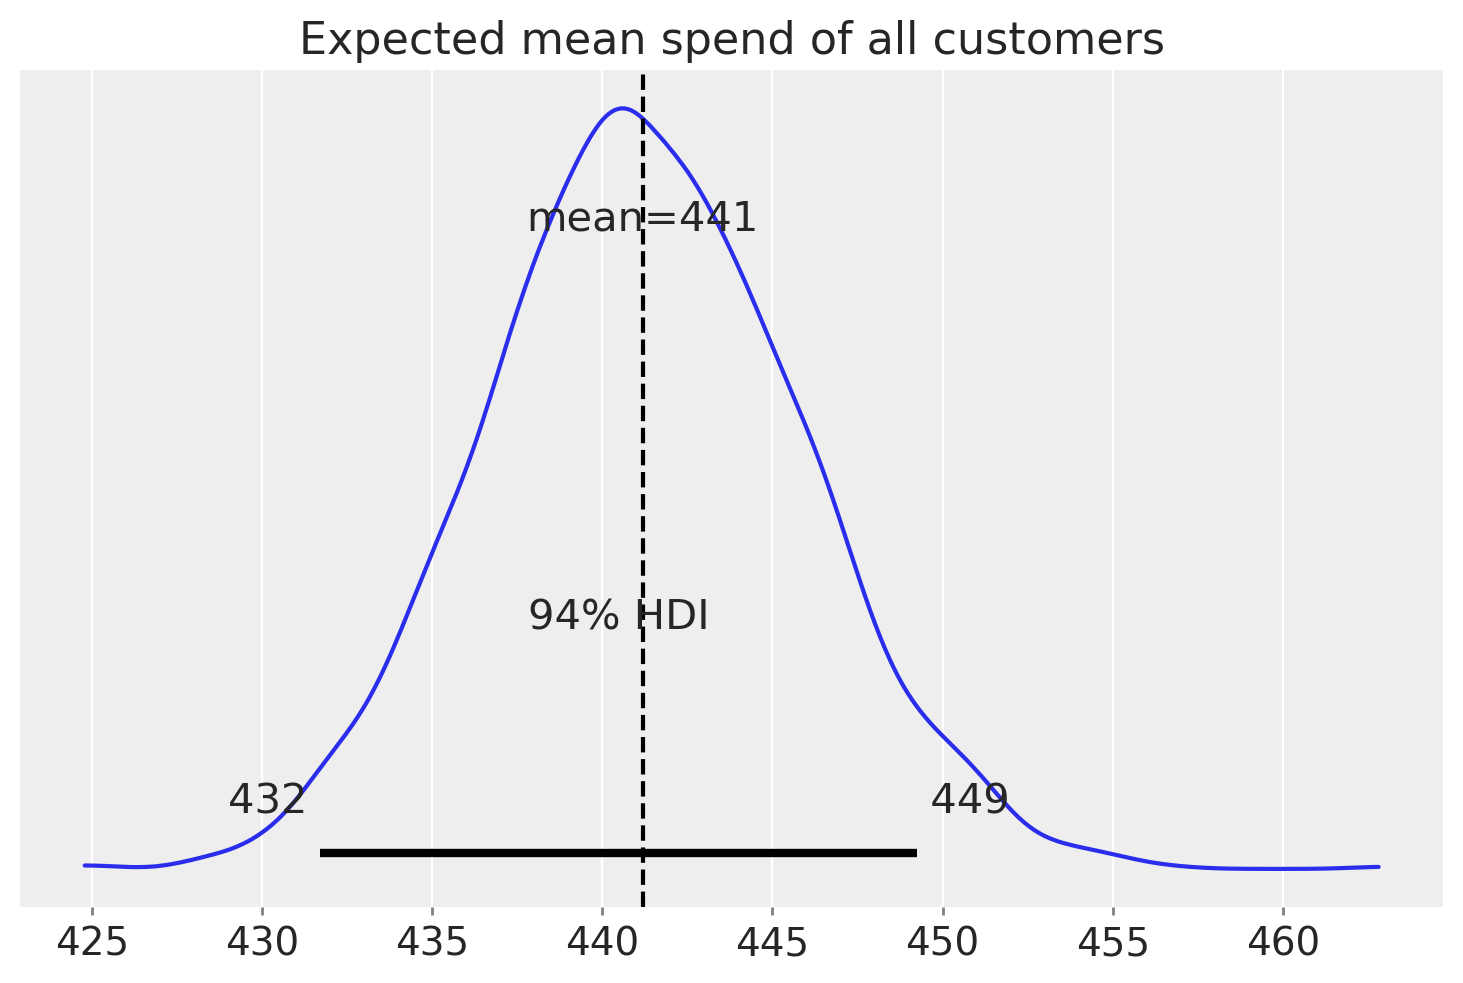

In [189]:
# Plotting the posterior distribution of the average expected spend for all customers.
# The vertical line represents the mean, giving a reference point against the distribution spread.

az.plot_posterior(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")
plt.title("Expected mean spend of all customers");

### Predicting New Customer Spending

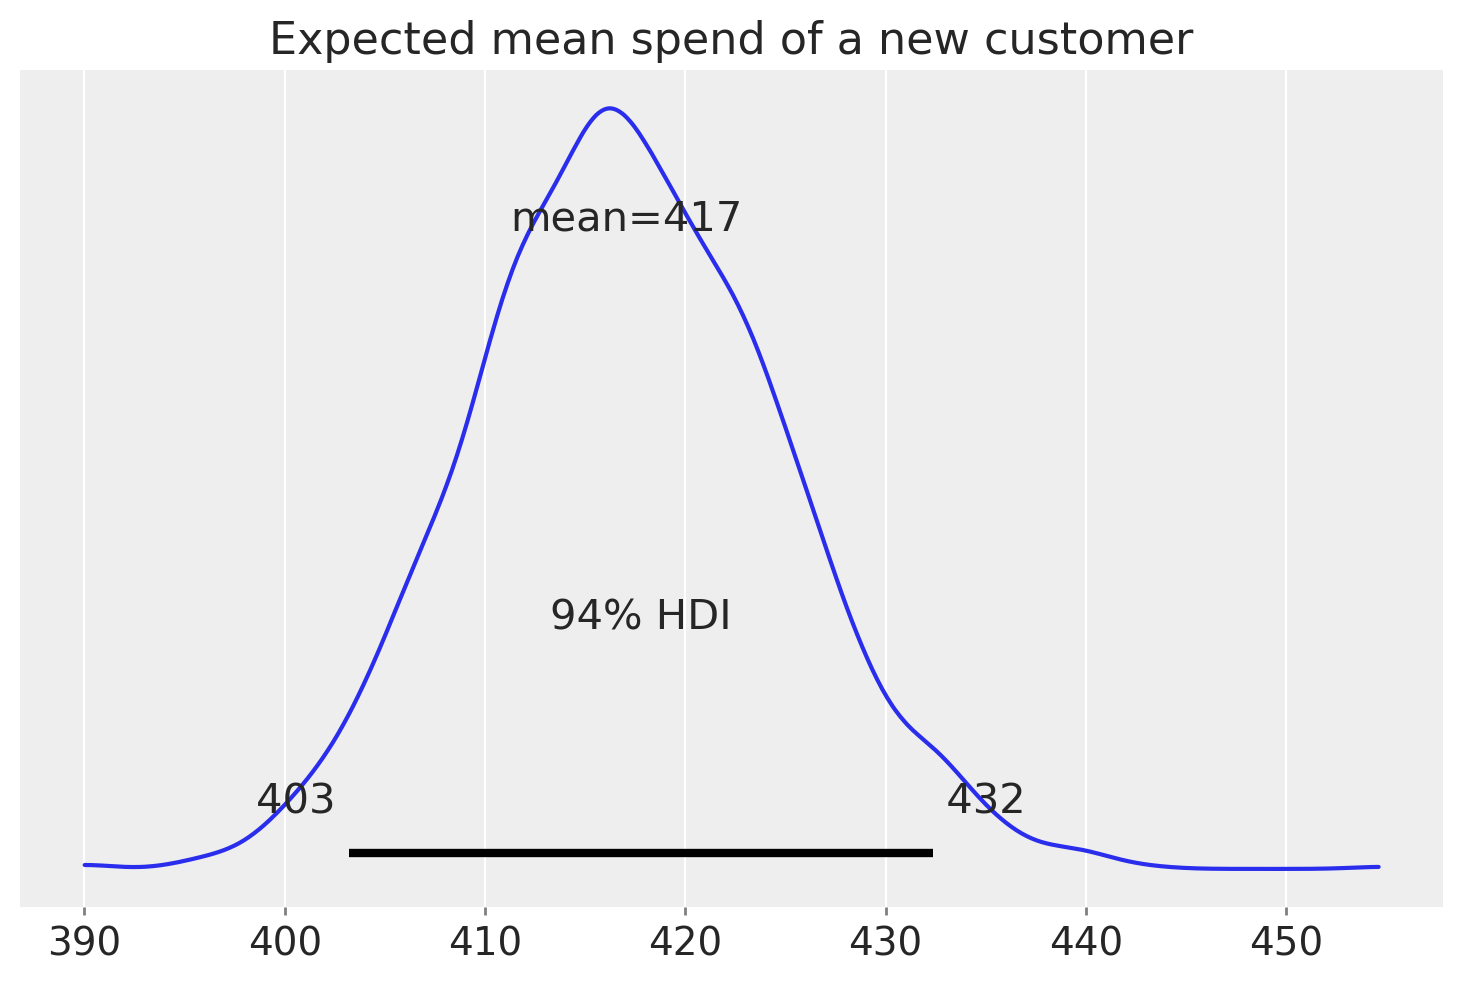

In [190]:
# Estimating the expected average spend of a hypothetical new customer.
# This prediction helps in budgeting and planning marketing strategies for customer acquisition.

az.plot_posterior(
    gg.expected_new_customer_spend()
)

plt.title("Expected mean spend of a new customer");

### Customer Lifetime Value (CLV) Estimation

Finally, we can combine the GG with the BG/NBD model to obtain an estimate of the customer lifetime value. This relies on the [Discounted cash flow](https://en.wikipedia.org/wiki/Discounted_cash_flow) model, adjusting for cost of capital:

In [191]:
# Estimating CLV using a Discounted Cash Flow approach, factoring in the time value of money with a discount rate.
# This method captures both the frequency and monetary value dimensions of CLV, offering a nuanced view of customer profitability.

clv_estimate = gg.expected_customer_lifetime_value(
    transaction_model=bgm,
    customer_id=data_summary_rfm['customer_id'],
    mean_transaction_value=data_summary_rfm["monetary_value"],
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"],
    time=120, # 120 months = 10 years
    discount_rate=0.01,
    freq="D",
)

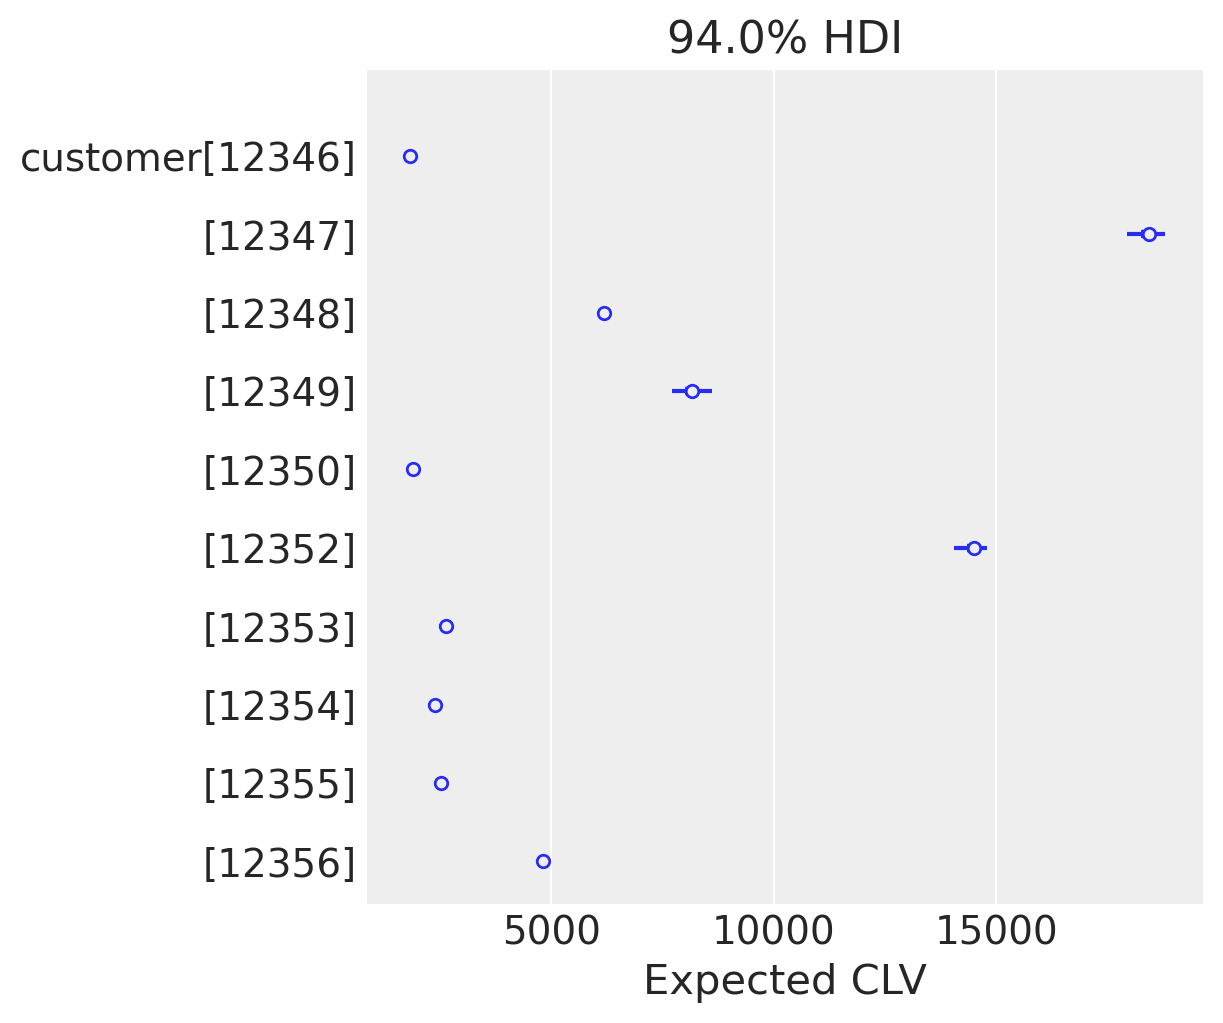

In [192]:
# Visualizing the estimated CLV for a subset of customers.
# The forest plot allows for easy comparison and highlights the variability in the projected CLVs.

az.plot_forest(clv_estimate.isel(customer_id=range(10)), combined=True, labeller=labeller)
plt.xlabel("Expected CLV");

In [193]:
# Reviewing the detailed CLV estimates, which are crucial inputs for strategic decisions like resource allocation,
# personalized marketing, and customer segmentation strategies.

clv_estimate

<xarray.DataArray (chain: 4, draw: 1000, customer_id: 4338)>
array([[[ 1778.21224815, 18647.91914055,  6205.58644949, ...,
          4997.39779326, 12255.51194351, 10793.31700058],
        [ 1778.18938443, 18651.83676152,  6228.80098306, ...,
          5052.20226137, 12363.26462879, 10770.00856236],
        [ 1823.16869244, 18702.8892484 ,  6286.49106411, ...,
          5199.58742804, 12455.4220108 , 10854.372873  ],
        ...,
        [ 1790.99208138, 18324.71497676,  6116.12624849, ...,
          4878.75840221, 12038.0825663 , 10546.67410595],
        [ 1924.08083952, 18705.78491536,  6405.55294167, ...,
          5473.89037358, 12683.16285061, 10902.64584513],
        [ 1769.36740655, 18394.70867964,  6242.75818867, ...,
          5222.5062738 , 12448.72440368, 10592.30679853]],

       [[ 1768.49940851, 18414.65844398,  6197.81302206, ...,
          5092.41706373, 12239.27149388, 10632.96029596],
        [ 1790.15733712, 17655.39782496,  6026.84529212, ...,
          4968.50170777, 11430.09025008, 10291.0492956 ],
        [ 1880.27398763, 18640.67937173,  6298.94654141, ...,
          5210.61392323, 12455.61509368, 10803.96125753],
...
        [ 1788.89366865, 18279.38941955,  6179.98806126, ...,
          5077.84526729, 12059.51824688, 10577.40646748],
        [ 1843.32422644, 18574.08057855,  6243.93146077, ...,
          5106.78810074, 12267.83660068, 10778.79970712],
        [ 1930.63940281, 18402.00237165,  6182.43552029, ...,
          4950.8827284 , 11964.95136977, 10695.20713364]],

       [[ 1712.15130605, 18526.8853976 ,  6210.98200379, ...,
          5090.0058487 , 12462.37637831, 10620.97194833],
        [ 1849.21745006, 18786.43233607,  6253.28736092, ...,
          5039.71574909, 12353.66595979, 10909.42711408],
        [ 1750.56370097, 18132.83266405,  6018.39154397, ...,
          4719.67687113, 11718.76925452, 10461.97774936],
        ...,
        [ 1860.28525825, 18569.4369253 ,  6184.02028442, ...,
          4916.7655778 , 12124.97000239, 10750.85687289],
        [ 1777.939396  , 18419.12223146,  6160.09460608, ...,
          4956.97570118, 12067.55868293, 10642.83555885],
        [ 1767.42374217, 18650.94272491,  6178.58254722, ...,
          4920.33436848, 12253.65998389, 10759.34090031]]])
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * customer_id  (customer_id) object '12346' '12347' ... '18283' '18287'

In [194]:
# Calculate the 94% HDI (Highest Density Interval)
hdi_data = az.hdi(clv_estimate, hdi_prob=0.94)  # Specify the probability for HDI as 94%

# Retrieve the results for each customer ID
hdi_per_customer = hdi_data.to_dataframe().unstack(level=0)

# Display the results
hdi_per_customer.head()  # Show the first few rows for review
""

''

### Exporting and Analyzing CLV Data

In [197]:
# Calculate the mean or median CLV for each customer. This collapses the draw and chain dimensions.
# We're using mean here, but you could use median or other statistics as needed.
mean_clv = clv_estimate.mean(dim=['draw', 'chain'])

# Create a DataFrame containing the customer IDs and their calculated CLV values
clv_df = pd.DataFrame({
    'customer_id': mean_clv.coords['customer_id'].values,  # Extracting customer IDs from the coordinates
    'clv_estimate': mean_clv.values  # The calculated mean CLVs
})

data_summary_rfm = data_summary_rfm.set_index('customer_id')

monetary_values = data_summary_rfm.loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values  # Assuming monetary_values aligns with customer_id


In [198]:
# Calculate the 94% HDI (Highest Density Interval)
hdi_data = az.hdi(clv_estimate, hdi_prob=0.94)

# Convert the HDI data to a DataFrame
hdi_df = hdi_data.to_dataframe().reset_index()
hdi_df.rename(columns={0: 'clv_estimate_lower_bound', 1: 'clv_estimate_upper_bound'}, inplace=True)

# Split the dataframe into two based on the 'hdi' column values 'lower' and 'higher'
lower_bounds = hdi_df[hdi_df['hdi'] == 'lower'][['customer_id', 'x']].rename(columns={'x': 'clv_estimate_lower_bound'})
higher_bounds = hdi_df[hdi_df['hdi'] == 'higher'][['customer_id', 'x']].rename(columns={'x': 'clv_estimate_upper_bound'})

# Merge the two dataframes on 'customer_id' to get a single dataframe with 'lower_x' and 'higher_x'
hdi_bounds = pd.merge(lower_bounds, higher_bounds, on='customer_id')

# Show the first few rows of the final dataframe
hdi_bounds.head()

,customer_id,clv_estimate_lower_bound,clv_estimate_upper_bound
0,12346,1707.105705,1934.331403
1,12347,17950.232585,18801.318303
2,12348,6045.911990,6320.833263
3,12349,7724.713966,8606.145240
4,12350,1775.231893,2010.502242


In [199]:
# Merge the HDI data with the CLV estimates
clv_df = pd.merge(clv_df, hdi_bounds, on='customer_id', how='left')

# Add the monetary value from the data_summary_rfm DataFrame
monetary_values = data_summary_rfm.loc[clv_df['customer_id'], 'monetary_value']
clv_df['monetary_value'] = monetary_values.values

# Calculate the gap between the CLV estimate and the actual monetary value
clv_df['gap'] = clv_df['clv_estimate'] - clv_df['monetary_value']

# Save the complete DataFrame to a CSV file, with columns as specified
clv_df = clv_df[['customer_id', 'clv_estimate', 'clv_estimate_lower_bound', 
                                   'clv_estimate_upper_bound', 'monetary_value', 'gap']]
clv_df.to_csv('clv_estimates_output.csv', index=False)


/var/folders/8y/d978l_411v9gwlklh7b5rydh0000gn/T/ipykernel_69212/2257015525.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


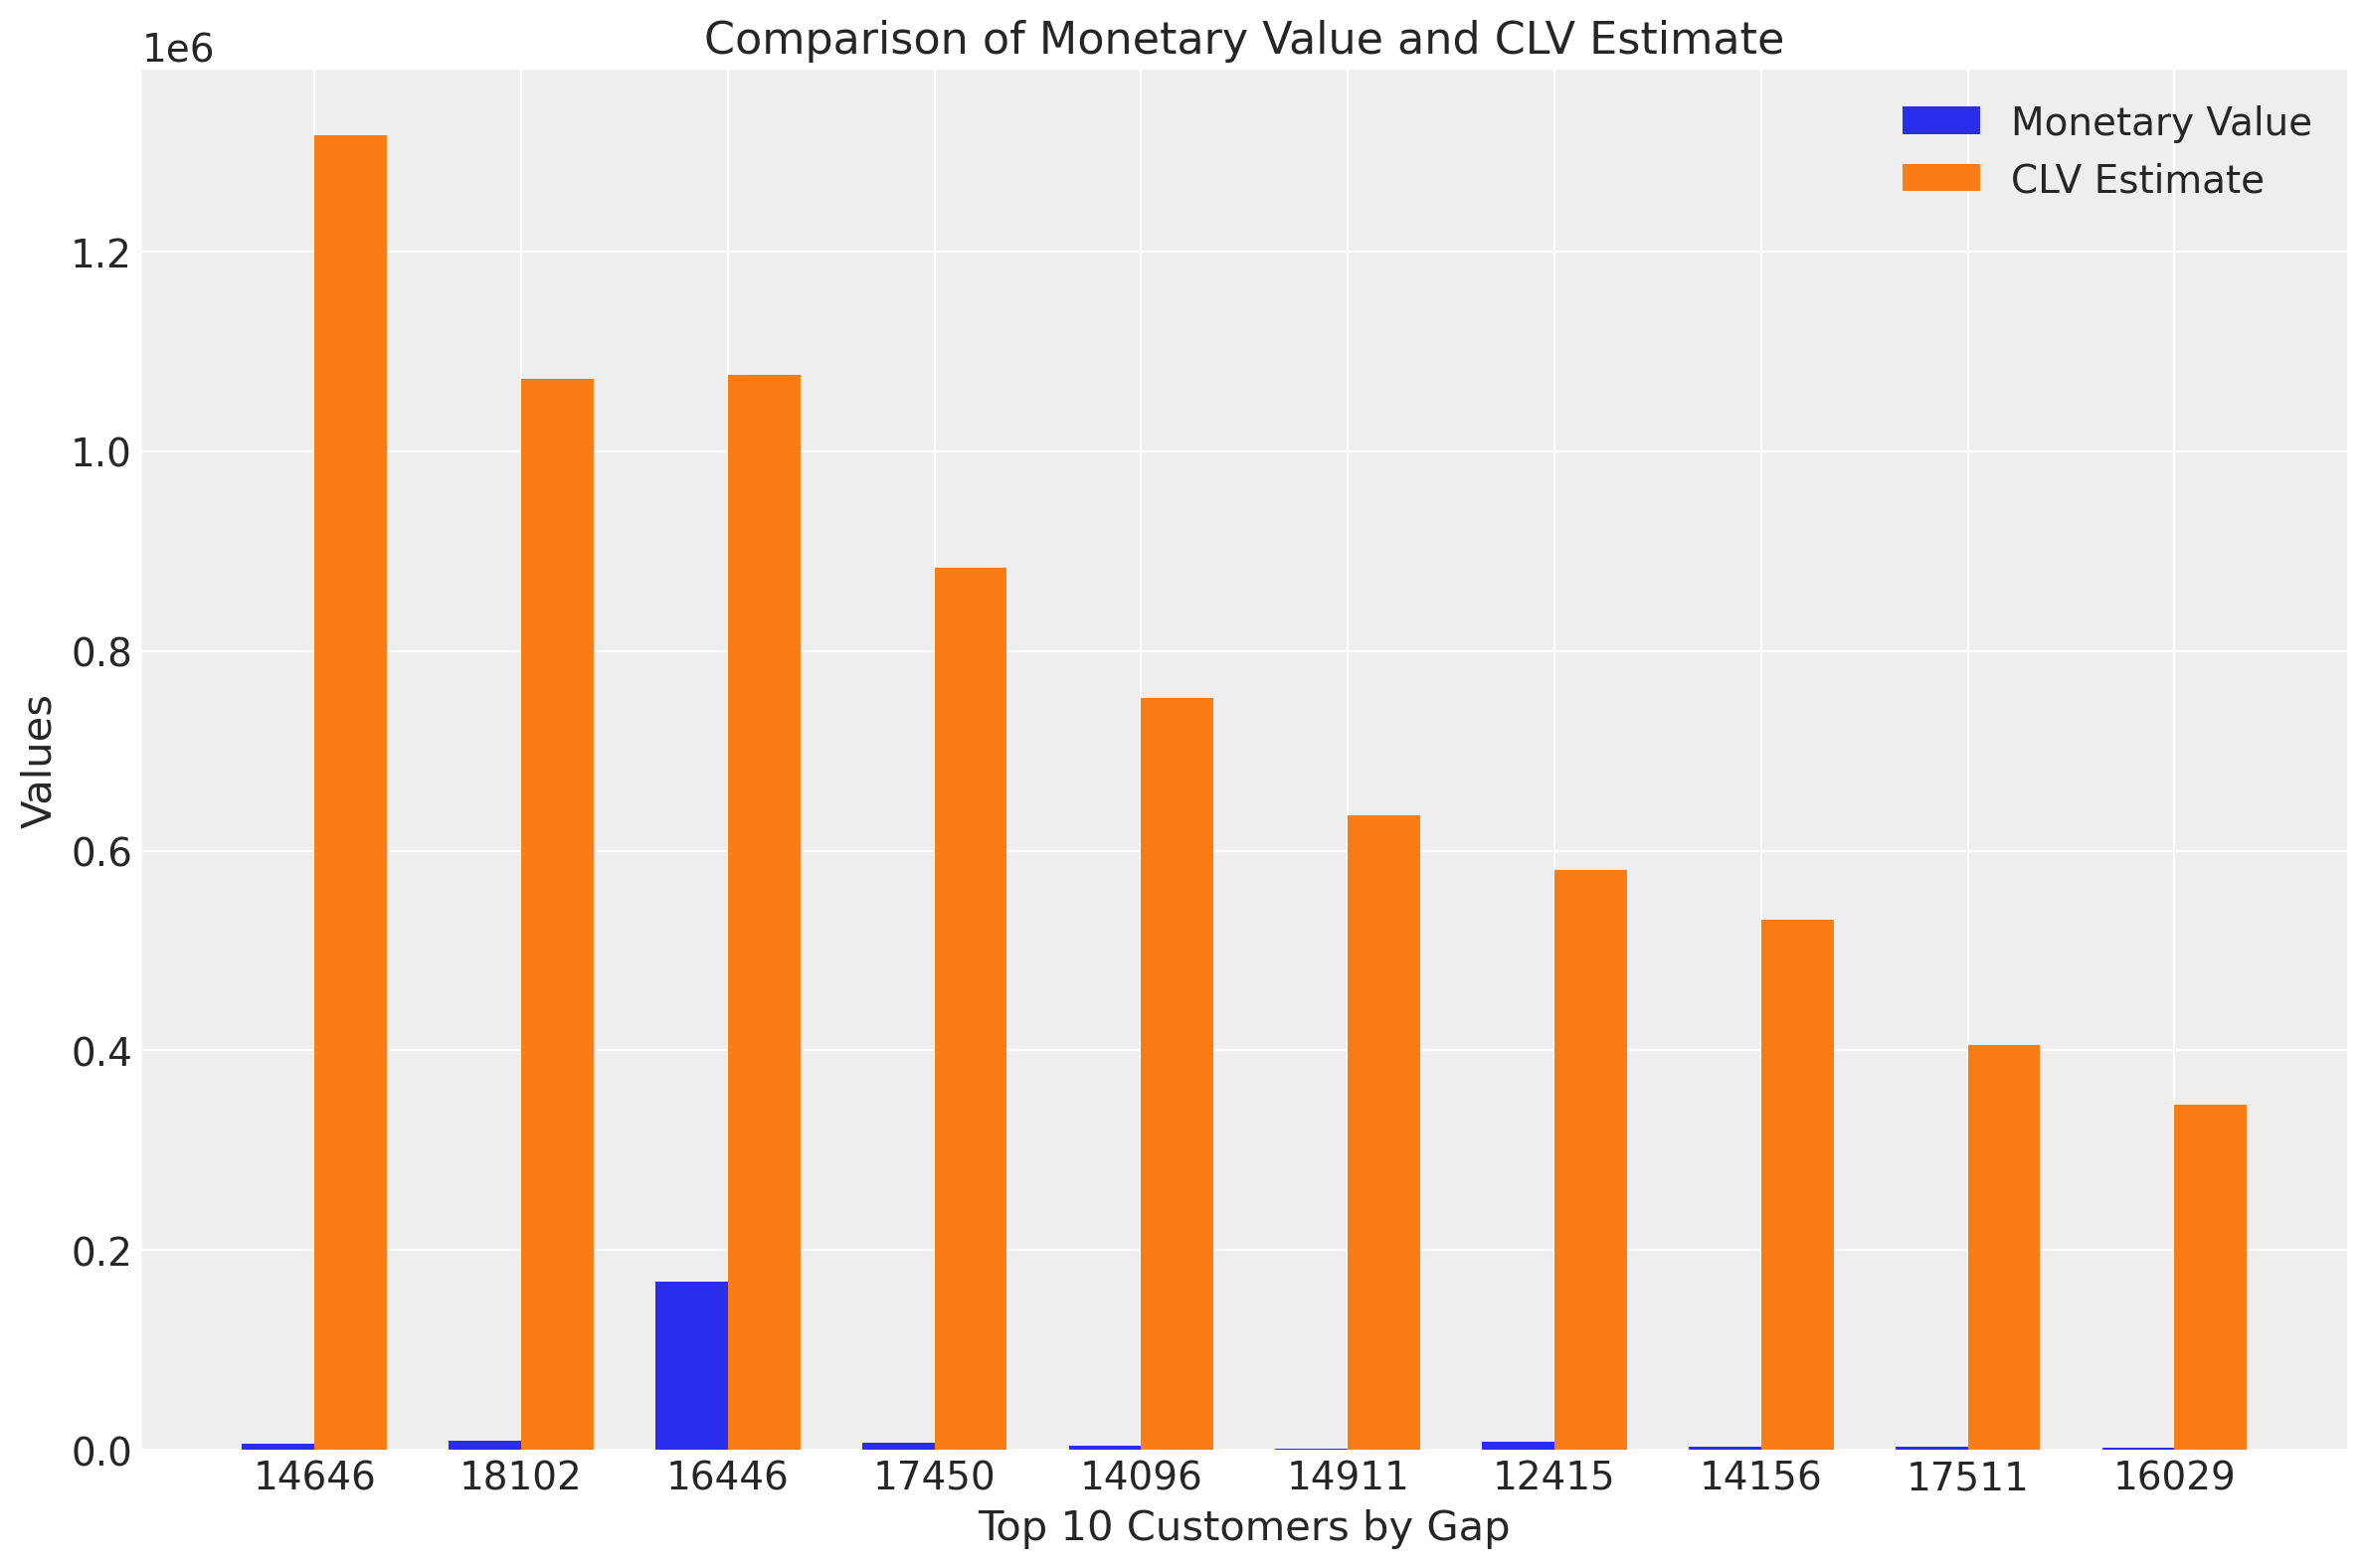

In [200]:
#  Now, we conduct a more nuanced analysis by exploring the 'gap' between a customer's historical spending and their projected CLV.
# This gap analysis helps identify customers with untapped potential, guiding resource allocation and personalized marketing campaigns.
import matplotlib.pyplot as plt

# Calculating the 'gap' between estimated CLV and historical monetary value for each customer.
clv_df['gap'] = clv_df['clv_estimate'] - clv_df['monetary_value']

# Sorting customers based on this 'gap' and selecting the top 10 customers with the largest positive gaps.
# These are customers whose future value significantly exceeds their past spending, representing prime opportunities for engagement.
top_10_gap = clv_df.sort_values(by='gap', ascending=False).head(10)

# Preparing a visual representation of this analysis. This bar chart compares historical spending with projected CLV,
# vividly illustrating the 'gap' and its implications for each of the top 10 customers.
fig, ax = plt.subplots(figsize=(12, 8))

# Setting up the positions for the bar components.
bar_width = 0.35
index = np.arange(len(top_10_gap))

# Bars representing the historical 'Monetary Value' for each customer. This is what each customer has previously contributed in terms of revenue.
bar1 = ax.bar(index, top_10_gap['monetary_value'], bar_width, label='Monetary Value')

# Bars showing the 'CLV Estimate' for each customer. This represents the future potential revenue from each customer, based on their projected lifetime value.
bar2 = ax.bar(index + bar_width, top_10_gap['clv_estimate'], bar_width, label='CLV Estimate')

# Enhancing the chart with labels, a title, and a legend for clarity.
ax.set_xlabel('Top 10 Customers by Gap')  # The x-axis shows the customers, sorted by the identified 'gap'.
ax.set_ylabel('Values')  # The y-axis represents the monetary amounts, both historical and projected.
ax.set_title('Comparison of Monetary Value and CLV Estimate')  # Chart title summarizing its purpose.
ax.set_xticks(index + bar_width / 2)  # Positioning the customer labels in the center of the grouped bars.
ax.set_xticklabels(top_10_gap['customer_id'])  # Customer IDs serve as the labels for the x-axis.
ax.legend()  # Including a legend makes the chart easier to interpret.

# Ensuring a clean layout before presenting the visualization. This step helps avoid any overlapping elements or clutter.
plt.tight_layout()

# Displaying the chart. This visualization serves as a strategic tool, highlighting where efforts could be concentrated for maximizing revenue.
plt.show()

In [201]:
# Calculating total sales per transaction
data['TotalSales'] = data['Quantity'] * data['UnitPrice']
customer_sales = data.groupby('CustomerID').agg({
    'TotalSales': sum,
    'Country': 'first'  # Assuming a customer is associated with only one country
})


customer_countries = customer_sales.reset_index()[['CustomerID', 'Country']]

clv_with_country = pd.merge(clv_df, customer_countries, left_on='customer_id', right_on='CustomerID', how='left')

average_clv_by_country = clv_with_country.groupby('Country')['clv_estimate'].mean()

customer_count_by_country = data.groupby('Country')['CustomerID'].nunique()

country_clv_summary = pd.DataFrame({
    'AverageCLV': average_clv_by_country,
    'CustomerCount': customer_count_by_country,
})

/var/folders/8y/d978l_411v9gwlklh7b5rydh0000gn/T/ipykernel_69212/2357846914.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  customer_sales = data.groupby('CustomerID').agg({


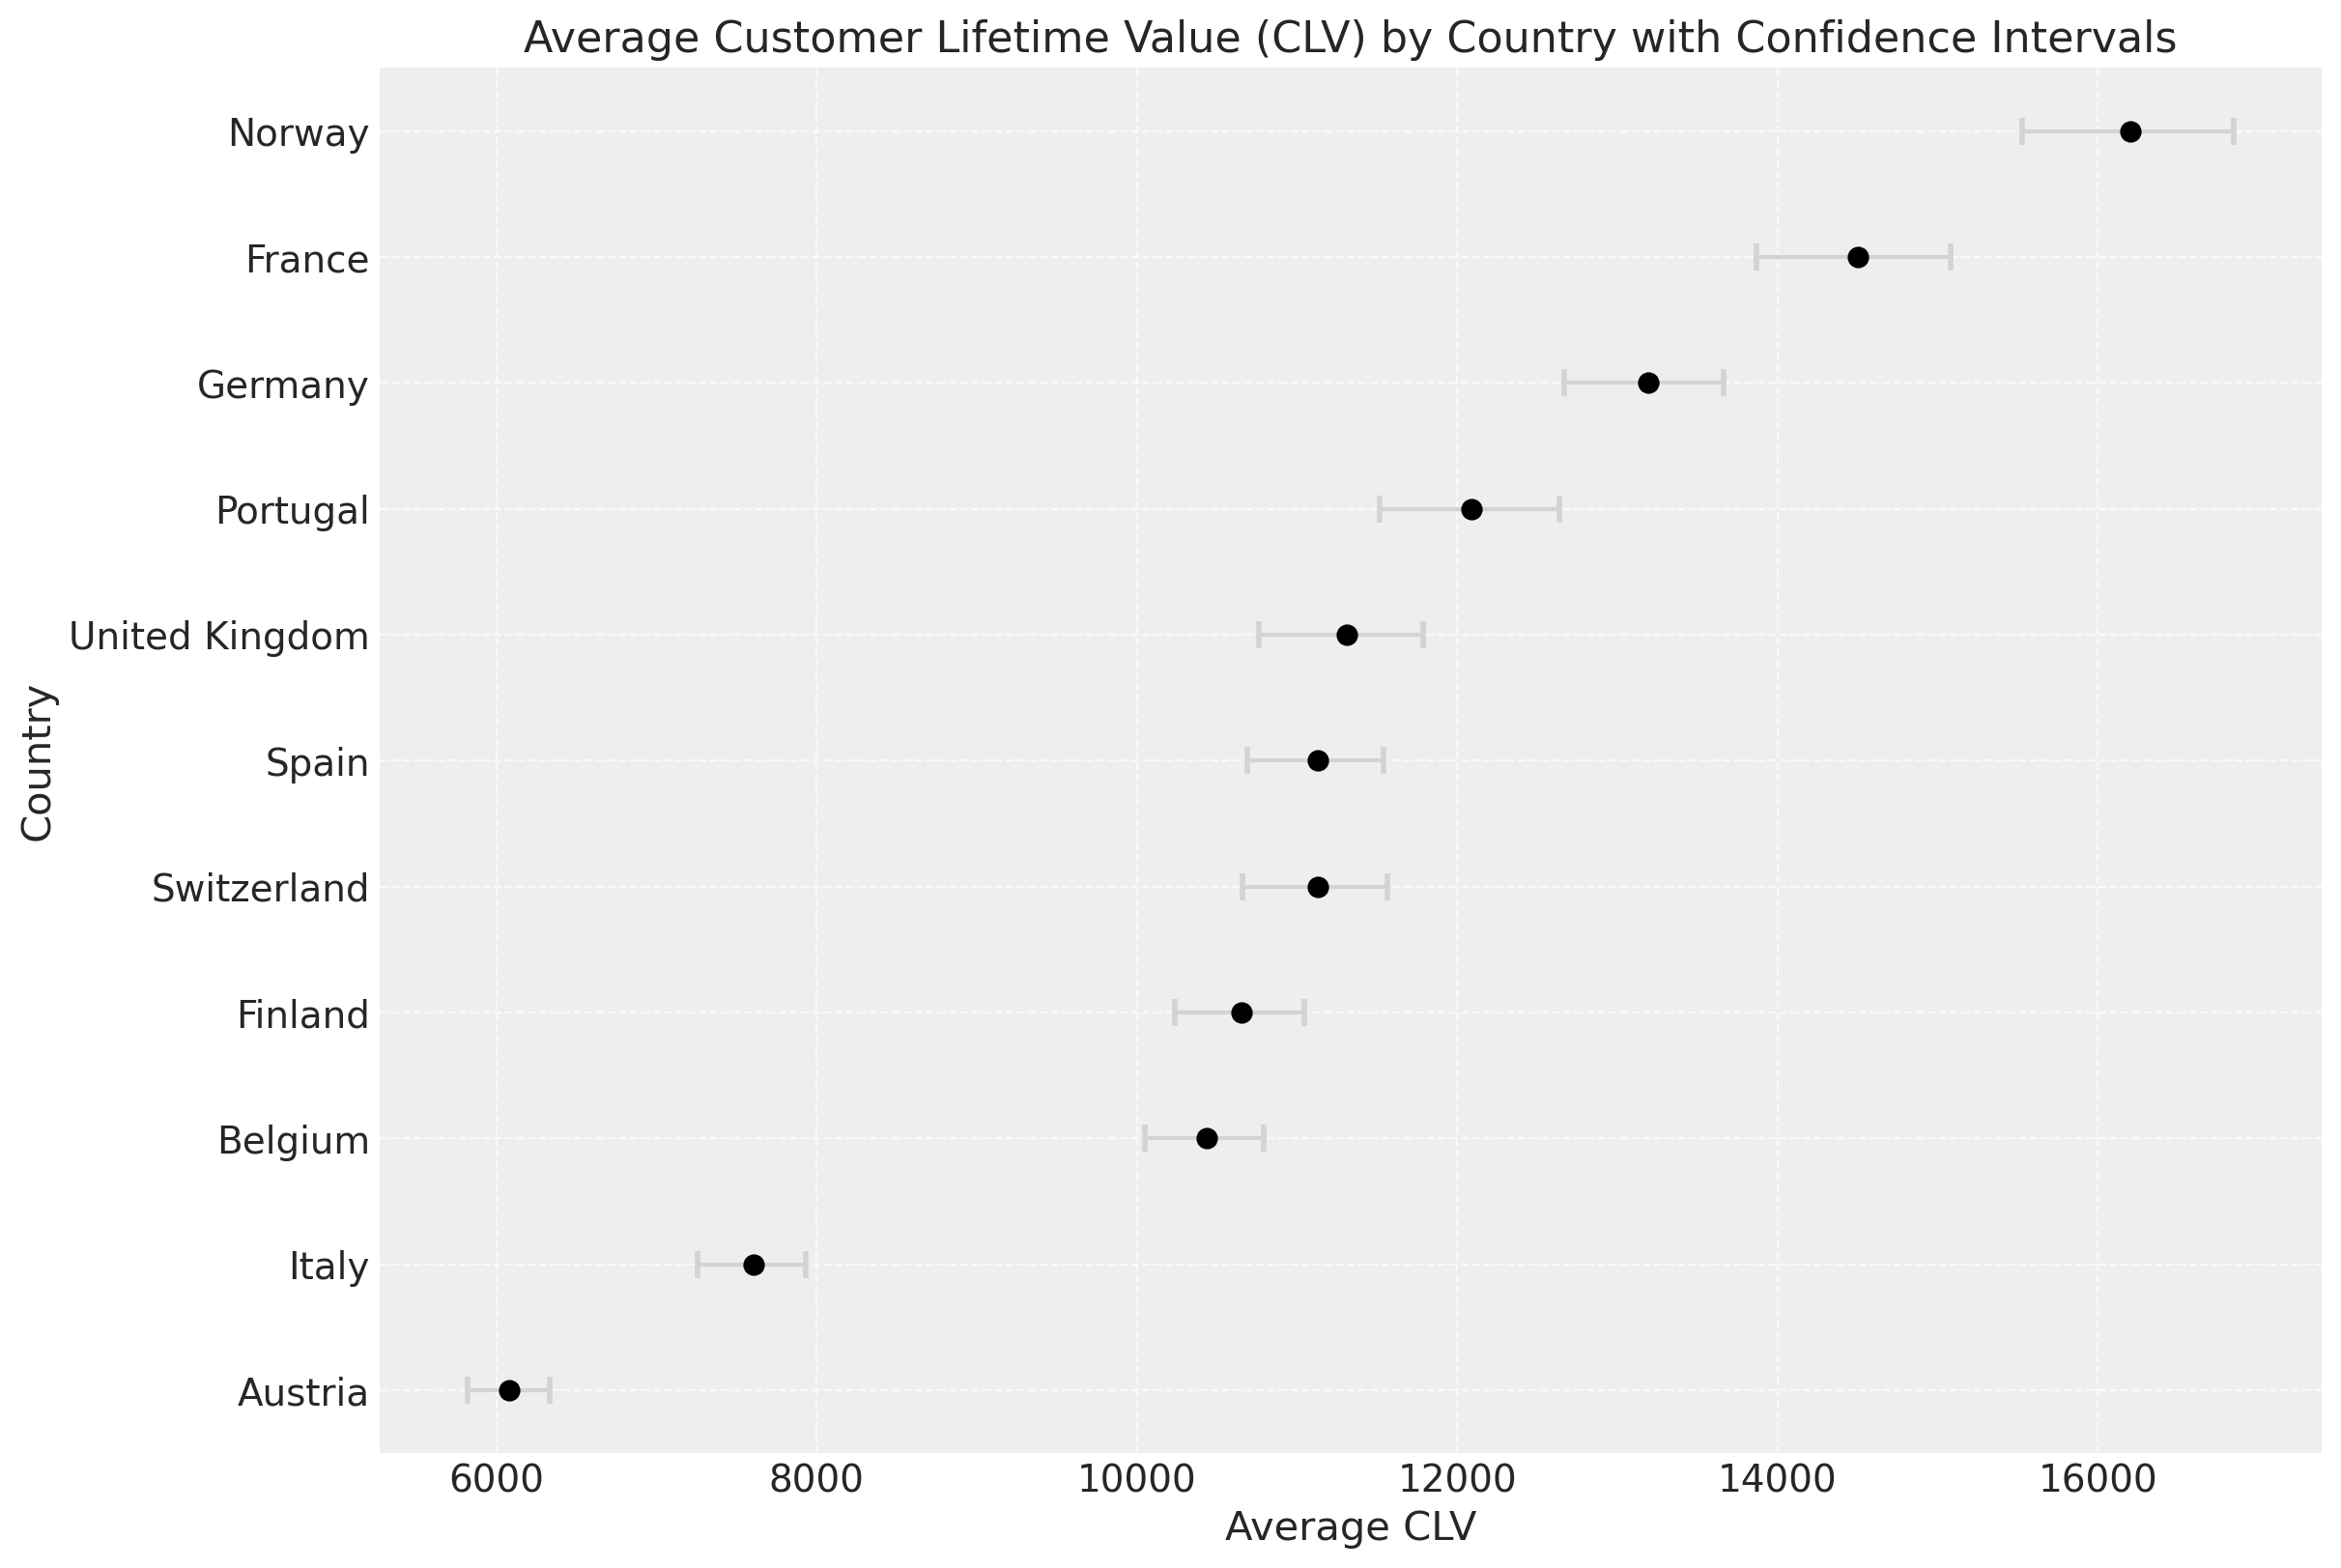

In [202]:
# Calculate the average lower and upper bounds of the CLV estimates by country
average_clv_lower_by_country = clv_with_country.groupby('Country')['clv_estimate_lower_bound'].mean()
average_clv_upper_by_country = clv_with_country.groupby('Country')['clv_estimate_upper_bound'].mean()

# Add these averages to the country_clv_summary dataframe
country_clv_summary['AverageCLVLower'] = average_clv_lower_by_country
country_clv_summary['AverageCLVUpper'] = average_clv_upper_by_country

# Filtering countries with more than 10 customers
filtered_countries = country_clv_summary[country_clv_summary['CustomerCount'] >= 10]

# Sorting in descending order by CustomerCount
sorted_countries = filtered_countries.sort_values(by='AverageCLV', ascending=False)

# Prepare the data for error bars
lower_error = sorted_countries['AverageCLV'] - sorted_countries['AverageCLVLower']
upper_error = sorted_countries['AverageCLVUpper'] - sorted_countries['AverageCLV']
asymmetric_error = [lower_error, upper_error]

# Create a new figure with a specified size
plt.figure(figsize=(12,8))

# Create a plot representing the average CLV with error bars indicating the confidence intervals
# We convert the index to a regular list to avoid issues with matplotlib's handling of pandas Index objects
plt.errorbar(x=sorted_countries['AverageCLV'], y=sorted_countries.index.tolist(), 
             xerr=asymmetric_error, fmt='o', color='black', ecolor='lightgray', capsize=5, markeredgewidth=2)

# Set labels and title
plt.xlabel('Average CLV')  # x-axis label
plt.ylabel('Country')  # y-axis label
plt.title('Average Customer Lifetime Value (CLV) by Country with Confidence Intervals')  # chart title

# Adjust the y-axis to display countries from top down
plt.gca().invert_yaxis()

# Show the grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()
